In [2]:
"""
The following python code has been developed as part of the 
assignment for the course Acquisition and Exploration of GeoData
Created by: Arun Vishwanath Venugopal (S2516306)
Submission date : February 1, 2022
"""
#Import the necessary packages

import urllib3
import json
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import math
from osgeo import ogr,gdal,gdal_array
import glob
import os
import pylab as pl
from scipy import stats

ModuleNotFoundError: No module named 'pandas'

In [408]:
# Access the data files from the url
luchtmeet_ds_url = "https://data.rivm.nl/data/luchtmeetnet/Voorlopig-jaar/"
response = urlopen(luchtmeet_ds_url).read()
soup = bs(response, 'html.parser')
air_quality_parameters = ["PM10","PM25"]

In [254]:
# read those csv files path and append it to a list
target = [[f"{luchtmeet_ds_url}{item['href']}"
          for item in soup.select(f"a[href$='.csv']")
          if i_air_param in item['href']]
          for i_air_param in air_quality_parameters
           ]

target = [x for x in target if x != []]


In [255]:
def get_avg_data_yearly(data,city):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: data - the nested list of csv files
    #         city - The city for which the stations are filtered
    # Purpose: To filter the data and sort them. Also provide the mean 
    #          for each station in the city
    # Returns: Dataframes in a list for each air quality variable,
    #          mean value for the station, exception value if occurred 

    output_frame = []
    try:
        for data_files in data:
            li = []
            l_first_file = True
            for filename in data_files:
                df = pd.read_csv(filename,header=1,delimiter=";",encoding = "ISO-8859-1")
                if l_first_file:
                    l_first_file = False
                    li.append(df)
                else:
                    li.append(df[6:])
            
                frame = pd.concat(li, axis=0, ignore_index=True)
            data_ams = frame.filter(like=city)
            cols = data_ams.columns

            mean_val = [[data_ams[i][0:5],data_ams[i][6:].astype(float).mean()] for i in cols]
            output_frame.append([frame,mean_val])
        return output_frame,None
    except Exception as e:
        return output_frame,e
        
    
air_quality_yearly,error = get_avg_data_yearly(target,"Amsterdam")

In [6]:
def get_files_by_month(data,month):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: data - (list) the nested list of csv files
    #         month - (int) the month value
    # Purpose: To filter the files and retrieve them for the given month
    # Returns: list of files for the given month

    monthly_files = []
    for data_files in data:
        for file_path in data_files:
            file_path_split = file_path.split("/")[-1]
            file_month = file_path_split.split("_")[1]
            if int(file_month) == month:
                monthly_files.append(file_path)
    return monthly_files

def get_avg_data_monthly(data,city,month):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: data - (list) the nested list of csv files
    #         city - (str) The city for which the stations are filtered
    #         month - (int) The month value
    # Purpose: To filter the data and sort them. Also provide the mean 
    #          for each station in the city
    # Returns: Dataframes in a list for each air quality variable,
    #          mean value for the station, exception value if occurred 

    output_frame = []
    try:
        data_files = get_files_by_month(data,month)
        
        for filename in data_files:
            df = pd.read_csv(filename,header=1,delimiter=";",encoding = "ISO-8859-1")
            data_ams = df.filter(like=city)
            cols = data_ams.columns
            mean_val = [[data_ams[i][0:5],data_ams[i][6:].astype(float).mean()] for i in cols]
            output_frame.append([df,mean_val])
        return output_frame,None
    except Exception as e:
        return output_frame,e

                
        
air_quality_monthly = [get_avg_data_monthly(target,"Amsterdam",i) for i in range(1,12)]

In [256]:
def get_mean_value_for_day(air_quality_param,day):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: air_quality_param - (Dataframe) The air quality data passed as a Dataframe 
    #         day - (str) The day to be filtered from the dataframe 
    #                     passed in the format "yyyymmdd"
    #         
    # Purpose: To filter the dataframe and get the mean value of the stations 
    #          for a given day.
    # Returns: A dict with key as station name and value as mean
    
    # Filter the DataFrame for stations in Amsterdam
    data_ams = air_quality_param.filter(like="Amsterdam")
    data_ams = data_ams[6:]
    data_cpy = air_quality_param.copy()
    data_cpy.columns = data_cpy.iloc[5]
    data_cpy  = data_cpy[6:]

    data_ams["Start_time"] = data_cpy["Begindatumtijd"]
    data_ams["End_time"] = data_cpy["Einddatumtijd"]

    # Get the values for the given day
    data_day = data_ams[data_ams['Start_time'].str.contains(day)]
    data_day_mean = dict()
    for i in data_day.columns:
        if i != "Start_time" and i != "End_time":
            # Compute the mean for all the values of that day for that station
            data_day_mean[i] = np.array(data_day[i]).astype(float).mean()
    return data_day_mean

In [278]:
def get_values_for_given_time(stations_list,formula,start_date,end_date):

    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: stations_list - (dict) dictionary with key as station name and 
    #                        value as a list of station code and coordinates
    #         formula - (str) The air quality parameter to be called. Eg: "PM10","PM25"
    #         start_date - (str) The starting date. Format as "yyyy-mm-dd"
    #         end_date - (str) The ending date. Format as "yyyy-mm-dd"
    # Purpose: calls the Luchtmeet API to get the values for a station within the start and end date.
    #          This method takes a list of stations and runs the api to get all the values 
    #          within the time period for all the stations
    # Returns: Geodataframe with mean value,List of the Tables with values (used later to plot correlation)
    
    
    http = urllib3.PoolManager()
    # Decalre the lists
    stations = []
    glat = []
    glon = []
    mval = []
    p_df_val = []
    for i_stat,j_list in stations_list.items():
        # Get the station number
        station_number = j_list[0]
        stations.append(station_number)
        coor = j_list[1].strip("()").split(",")
        # Get the latitude and longitude
        lat,lon = float(coor[0]),float(coor[1])
        glat.append(lat)
        glon.append(lon)
        # The url that will return a json
        url = f"https://api.luchtmeetnet.nl/open_api/measurements?end={end_date}T00:00:00&start={start_date}T00:00:00&"
        url+=f"order_direction=asc&order_by=timestamp_measured&formula={formula}&station_number={station_number}"
        request = http.request('GET', url)
        # data consists of the json response from the api
        data = json.loads(request.data)
        # Set the temp Dataframe and append to a list 
        p_temp = pd.DataFrame(data["data"])
        p_df_val.append(p_temp)
        # Get the mean of all the values from that station
        p_temp_mean = p_temp["value"].mean()        
        mval.append(p_temp_mean)


    temp_df = pd.DataFrame({
        "station_number":stations,
        "mean_val":mval,
        "lat":glat,
        "lon":glon
    })
    # Create the geodataframe
    geopd = gpd.GeoDataFrame(temp_df,
                           geometry=gpd.points_from_xy(temp_df.lon, temp_df.lat),
    crs="EPSG:4326")
    return geopd,p_df_val

In [302]:
# Filter the pm10 and pm2.5 Columns for Amsterdam
filtpm10_ams = air_quality_yearly[0][0].filter(like="Amsterdam")
filtpm25_ams = air_quality_yearly[1][0].filter(like="Amsterdam")

# Get the pm10 and pm2.5 stations for Amsterdam. Dict with key as 
# station name and values as station_code and its coordinates
pm10_stations = {i:[filtpm10_ams[i][5],filtpm10_ams[i][0]] for i in filtpm10_ams}
pm25_stations = {i:[filtpm25_ams[i][5],filtpm25_ams[i][0]] for i in filtpm25_ams}

pm10jan28,pm10jan28_val = get_values_for_given_time(pm10_stations,"PM10","2022-01-28","2022-01-29")
pm25jan28,pm25jan28_val = get_values_for_given_time(pm25_stations,"PM25","2022-01-28","2022-01-29")

pm10jan1,pm10jan1_val = get_values_for_given_time(pm10_stations,"PM10","2021-01-01","2021-01-02")
pm25jan1,pm25jan1_val = get_values_for_given_time(pm25_stations,"PM25","2021-01-01","2021-01-02")

In [410]:
# Get January 1 2021 values
date = "20210101"
pm10_day = get_mean_value_for_day(air_quality_yearly[0][0],date)
pm25_day = get_mean_value_for_day(air_quality_yearly[1][0],date)

In [259]:
pm10 = air_quality_yearly[0][1]
pm25 = air_quality_yearly[1][1]

In [411]:
def get_geodf(air_q_df,mean_val=None):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: air_q_df - (Dataframe) The table to convert to geoDataframe
    #         mean_val - (list) or (None) The list of mean values. Taken from the
    #                    Dataframe if not provided.
    # Purpose: To create a Geodataframe with spatial reference from the given
    #          Dataframe
    # Returns: GeoDataframe (None in case of a ValueError)
    
    try:
        lat,lon = zip(*[i_stat[0][0].strip("()").split(",")                    
                        for i_stat in air_q_df])
        if mean_val is None:
            mean_val = [i_stat[1] for i_stat in air_q_df]
        station_name = [i_stat[0].name for i_stat in air_q_df]
        coor = pd.DataFrame(
            {'district': station_name,
            'latitude':lat,
             'longitude':lon
            })
        geo_df = gpd.GeoDataFrame(
            coor, 
            geometry=gpd.points_from_xy(coor.longitude, coor.latitude),
            crs="EPSG:4326"
        )
        geo_df["mean_air_q"]= mean_val
        return geo_df
    except ValueError:
        return None

In [412]:
pm10_yearly_geo_df,pm25_yearly_geo_df = [get_geodf(i) for i in [pm10,pm25]]

# Mean values provided for a day
pm10_day_geo_df,pm25_day_geo_df = [get_geodf(i[0],mean_val=i[1]) 
                                     for i in [[pm10,pm10_day.values()],
                                               [pm25,pm25_day.values()]]
                                                                ]

In [413]:
# Save to shape file
pm10_yearly_geo_df.to_file("output/pm10_yearly_amst.shp")
pm25_yearly_geo_df.to_file("output/pm25_yearly_amst.shp")


In [290]:
pm10_day_geo_df.to_file("output/pm10_day_amst.shp")
pm25_day_geo_df.to_file("output/pm25_day_amst.shp")


pm25jan28.to_file("output/pm25jan28.shp")
pm10jan28.to_file("output/pm10jan28.shp")

C:\Users\HP\AppData\Local\Temp/ipykernel_3980/1949205783.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pm25jan28.to_file("output/pm25jan28.shp")
C:\Users\HP\AppData\Local\Temp/ipykernel_3980/1949205783.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pm10jan28.to_file("output/pm10jan28.shp")


In [291]:
shape_file_paths = ["output/pm10_yearly_amst.shp","output/pm25_yearly_amst.shp"]

day_shp_file_paths = ["output/pm10_day_amst.shp","output/pm25_day_amst.shp"]

jan28shp_file_paths = ["output/pm25jan28.shp","output/pm10jan28.shp"]

In [414]:
def get_idw_interpolation(shape_file_path, power = 3,zfield="mean_air_q",rasterXsize = 500,rasterYsize = 500):    
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: shape_file_path - path of the point layers
    #         power - (int) Optional value to set the degree of weightage.
    #                  Higher the power, higher values for nearer points. 
    #                  Default is set to 3
    #         zfield - (str) The attribute name to interpolate
    #         rasterXsize - (int) The width of the output raster.
    #         rasterYsize - (int) The height of the output raster.
    # Purpose: Performs the IDW interpolation on the air quality data of Amsterdam
    # Returns: idw - the output raster object
    #          idw_array - the output gdal array

    
    # Amsterdam city extent
    ulx = 4.71
    uly = 52.5
    lrx = 5.08
    lry = 52.27
    
    idw = gdal.Grid("Mem",shape_file_path,zfield=zfield,
                   algorithm=f"invdist:power={power}:radius1=2000:radius2=2000",outputBounds = [ulx,uly,lrx,lry],
                   width = rasterXsize, height = rasterYsize)
    idw_array = gdal_array.DatasetReadAsArray(idw)
    return idw,idw_array



In [360]:
# Performs Interpolation for january to june 2021
pm10_idw,pm25_idw = [get_idw_interpolation(i) for i in shape_file_paths]

# Performs Interpolation for january 1 2021
pm10_day_idw,pm25_day_idw = [get_idw_interpolation(i) for i in day_shp_file_paths]

# Performs Interpolation for january to june 2021 with raster width and height as 
# to get better road layer
pm10_1500idw,pm25_1500idw = [get_idw_interpolation(i,rasterXsize = 1500,rasterYsize = 1500) 
                             for i in shape_file_paths]


pm10_jan1_idw,pm25_jan1_idw = [get_idw_interpolation(i,rasterXsize = 1500,rasterYsize = 1500) 
                               for i in day_shp_file_paths]

# Performs Interpolation for january 28 2022
pm25jan28_idw,pm10jan28_idw = [get_idw_interpolation(i,zfield="mean_val") for i in jan28shp_file_paths]
pm25jan28_1500idw,pm10jan28_1500idw = [get_idw_interpolation(i,zfield="mean_val",rasterXsize=1500,rasterYsize=1500) 
                                       for i in jan28shp_file_paths]

In [ ]:
def plot_idw(pm10,pm25,title,output_file_name):
    
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: pm10 - (numpy.array) array of pm10 values
    #         pm25 - (numpy.array) array of pm2.5 values
    #         title - (str) The title of the plot
    #         output_file_name - (str) The file name to be saved.
    #      
    # Purpose: Plots the IDW interpolation on the air quality data 
    #          and saves the plot
    # Returns: None
    
    fig,ax = plt.subplots(1, 2, figsize=(20,10),sharey=True,sharex=True,squeeze=False)
    fig.suptitle(title,fontsize=30)
    pm10_plt = ax[0,0].imshow(pm10,cmap='Reds')
    fig.colorbar(pm10_plt,ax=ax[0,0]).set_label(size=15,label="Air Quality level (µg/$m^3$)")
    ax[0,0].set_title("PM 10 Interpolation",fontsize=20)
    ax[0,0].axis('off')
    pm25_plt = ax[0,1].imshow(pm25,cmap='Reds')
    fig.colorbar(pm25_plt,ax=ax[0,1]).set_label(size=15,label="Air Quality level (µg/$m^3$)")
    ax[0,1].set_title("PM 2.5 Interpolation",fontsize=20)
    ax[0,1].axis('off')
    # Save figure as png
    fig.savefig(f"output/{output_file_name}.png")

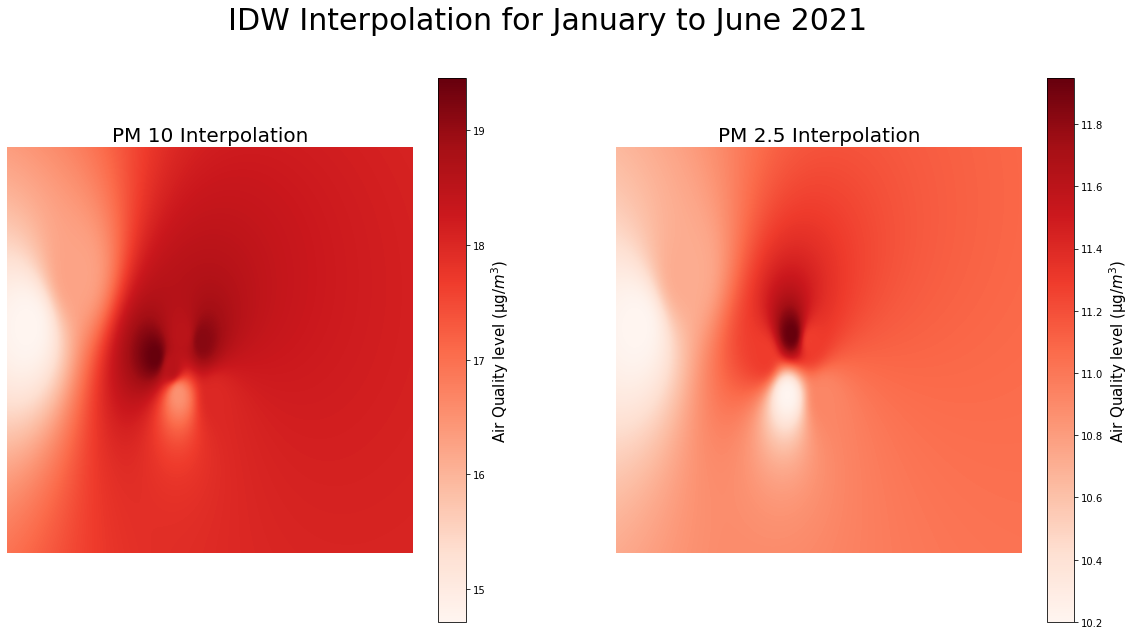

In [293]:
plot_idw(pm10_idw[1],pm25_idw[1],"IDW Interpolation for January to June 2021","Interpolated_pm10_pm25_jan_jun21")

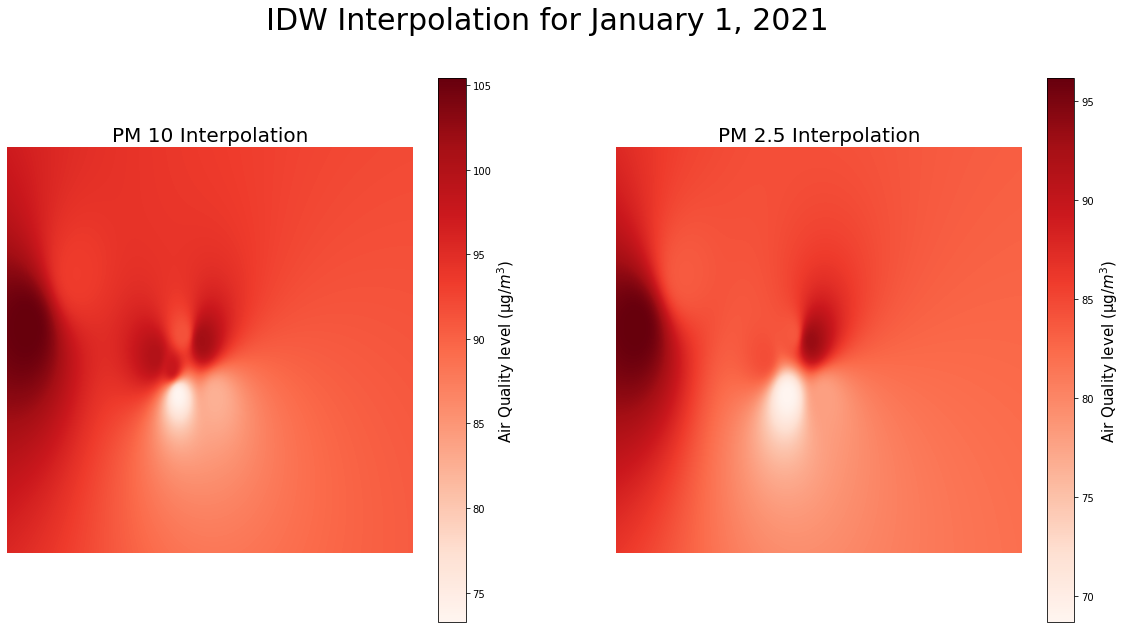

In [294]:
plot_idw(pm10_day_idw[1],pm25_day_idw[1],"IDW Interpolation for January 1, 2021","Interpolated_pm10_pm25_jan1")

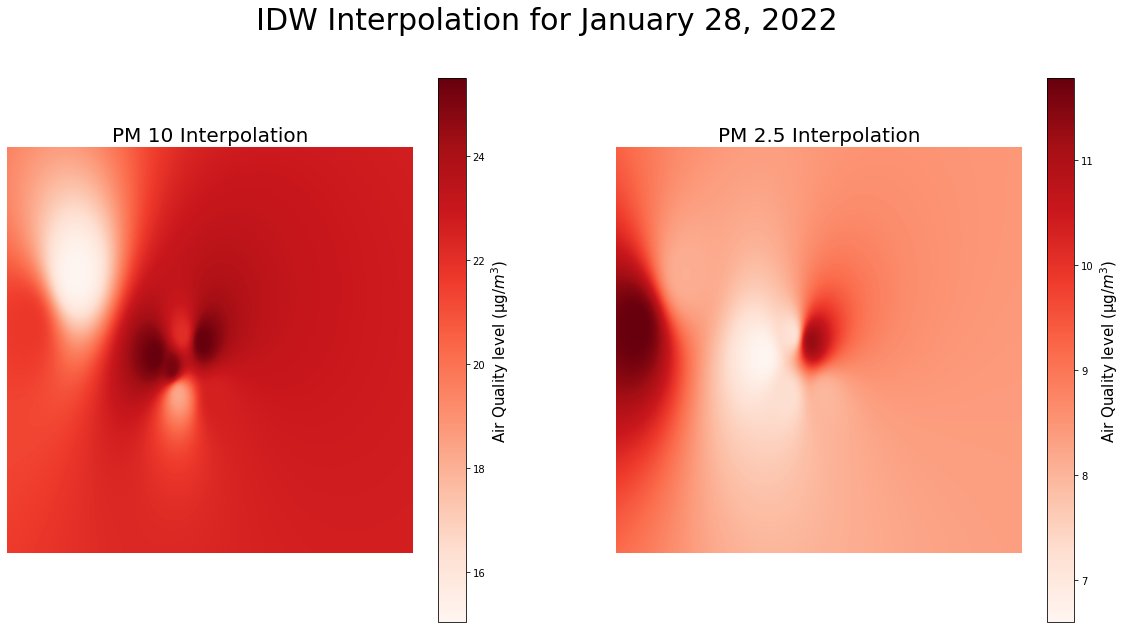

In [295]:
plot_idw(pm10jan28_idw[1],pm25jan28_idw[1],"IDW Interpolation for January 28, 2022","Interpolated_pm10_pm25_jan28_2022")

In [416]:
def get_hist(data_ams,air_var):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: data_ams - (DataFrame) Table of air quality values for Amsterdam stations
    #         air_var - (str) Air quality variable. "PM10" or "PM2.5"
    #         
    # Purpose: Plots the histogram on the air quality data 
    #          and saves the plot
    # Returns: None
    
    col = math.ceil(len(data_ams.columns)/2)
    fig,ax = plt.subplots(2,col,figsize=(25,15),squeeze = False)
    fig.suptitle(air_var + " Histogram for the Amsterdam stations from January to June 2021",fontsize=30)
    for i in range(len(data_ams.columns)):
        d1_tmp = data_ams[data_ams.columns[i]][6:]
        d1 = d1_tmp[d1_tmp.notnull()].astype(float)        
        if i >= col:
            ax[1,i-col].hist(d1,bins=500)
            ax[1,i-col].set_title(data_ams.columns[i],fontsize=15)
        else:
            ax[0,i].hist(d1,bins=500)
            ax[0,i].set_title(data_ams.columns[i],fontsize=15)
    fig.savefig(f"output/{air_var}_hist_jan_jun.png")



In [415]:
def get_boxplot(data_ams,air_var):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: data_ams - (DataFrame) Table of air quality values for Amsterdam stations
    #         air_var - (str) Air quality variable. "PM10" or "PM2.5"
    #         
    # Purpose: Plots the boxplot on the air quality data 
    #          and saves the plot
    # Returns: None
    
    col = math.ceil(len(data_ams.columns)/2)
    fig,ax = plt.subplots(2,col,figsize=(25,15),squeeze = False)
    fig.suptitle(air_var + " Boxplot for the Amsterdam stations from January to June 2021",fontsize=30)
    for i in range(len(data_ams.columns)):
        d1_tmp = data_ams[data_ams.columns[i]][6:]
        d1 = d1_tmp[d1_tmp.notnull()].astype(float)        
        if i >= col:
            ax[1,i-col].boxplot(d1,meanline=True)
            ax[1,i-col].set_title(data_ams.columns[i],fontsize=15)
        else:
            ax[0,i].boxplot(d1,meanline=True)
            ax[0,i].set_title(data_ams.columns[i],fontsize=15)
    fig.savefig(f"output/{air_var}_boxplot_jan_jun.png")

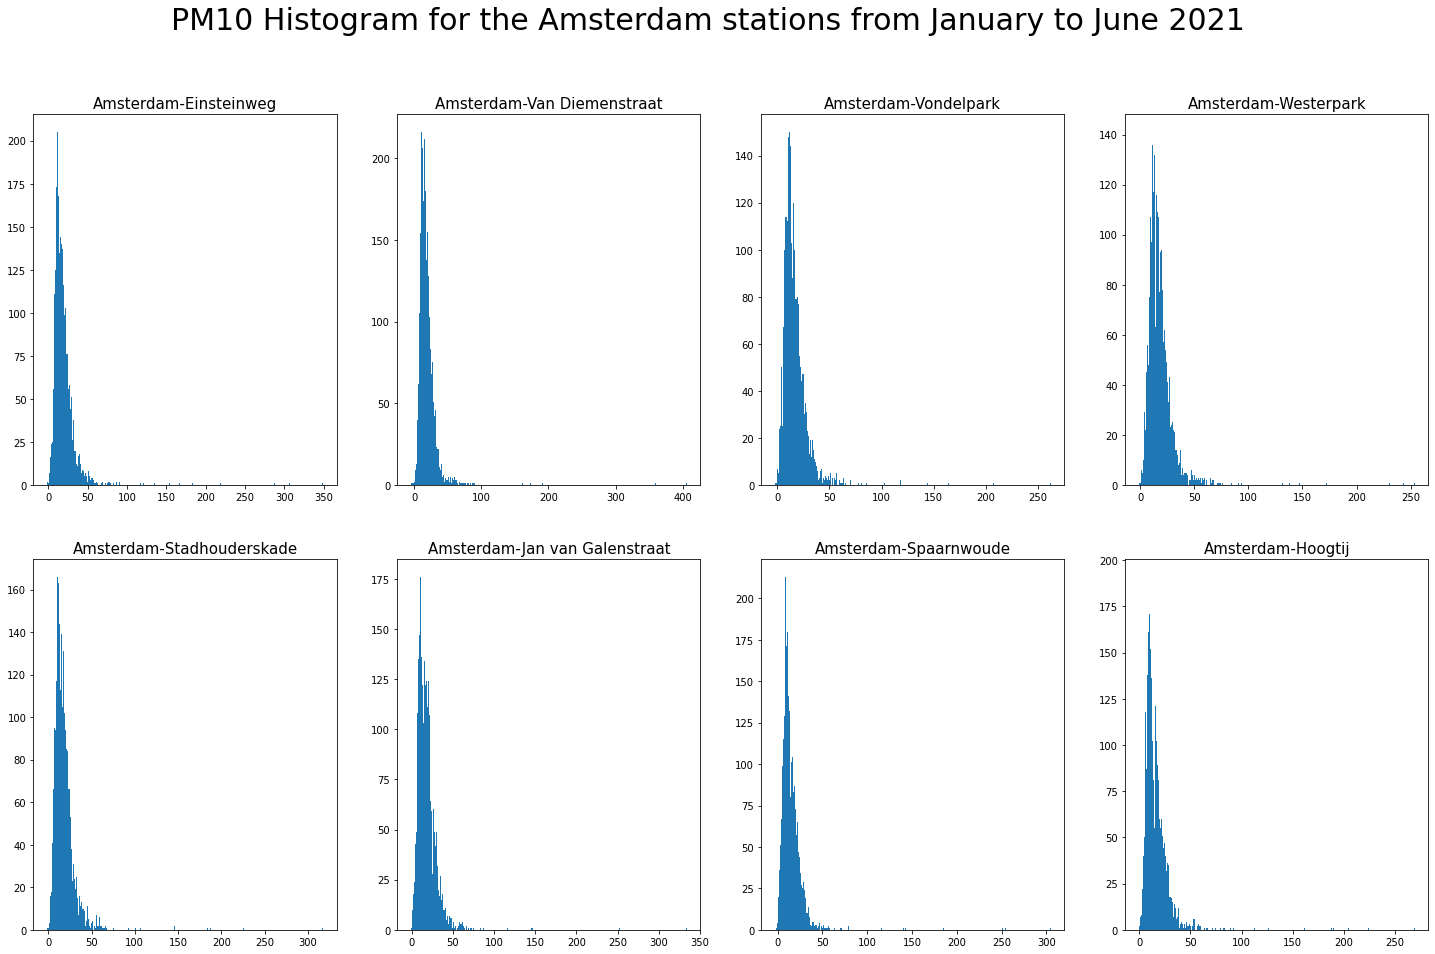

In [417]:
get_hist(filtpm10_ams,"PM10")

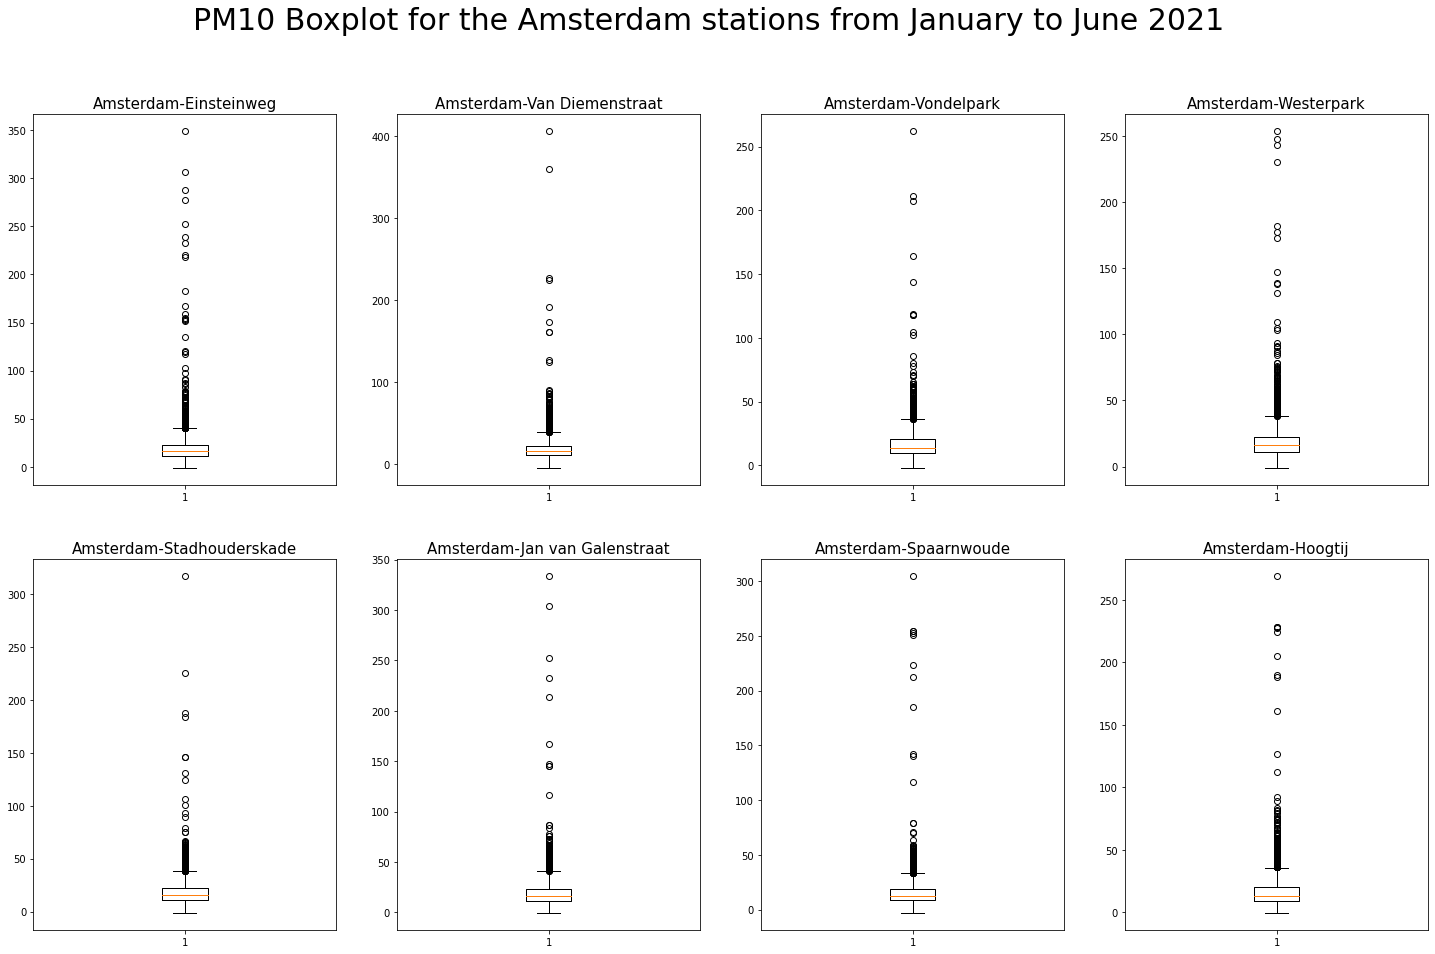

In [418]:
get_boxplot(filtpm10_ams,"PM10")

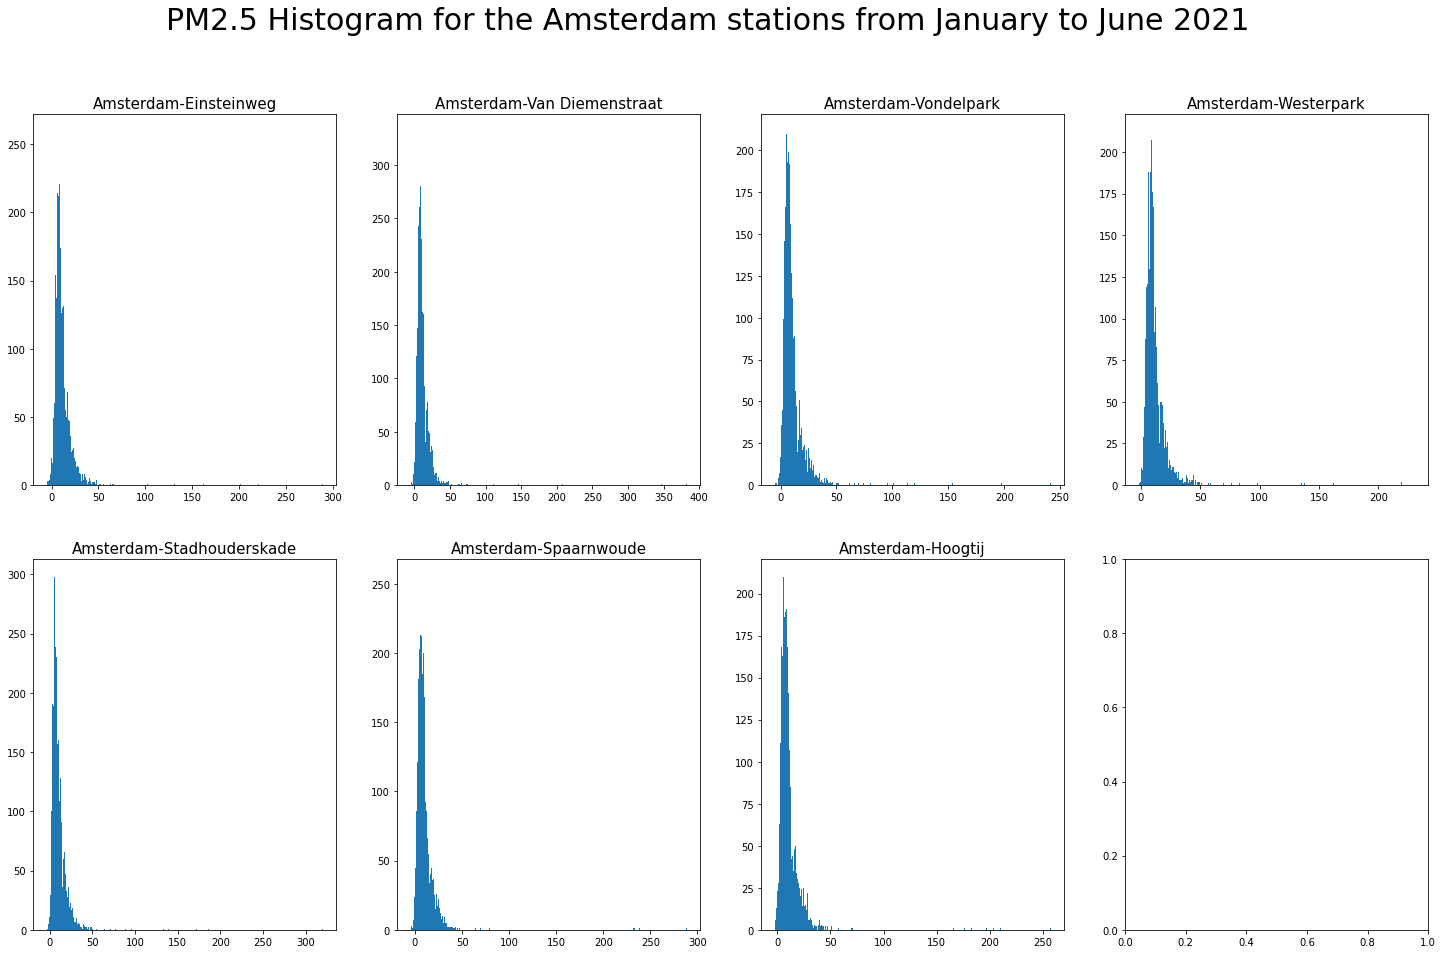

In [287]:
get_hist(filtpm25_ams,"PM2.5")

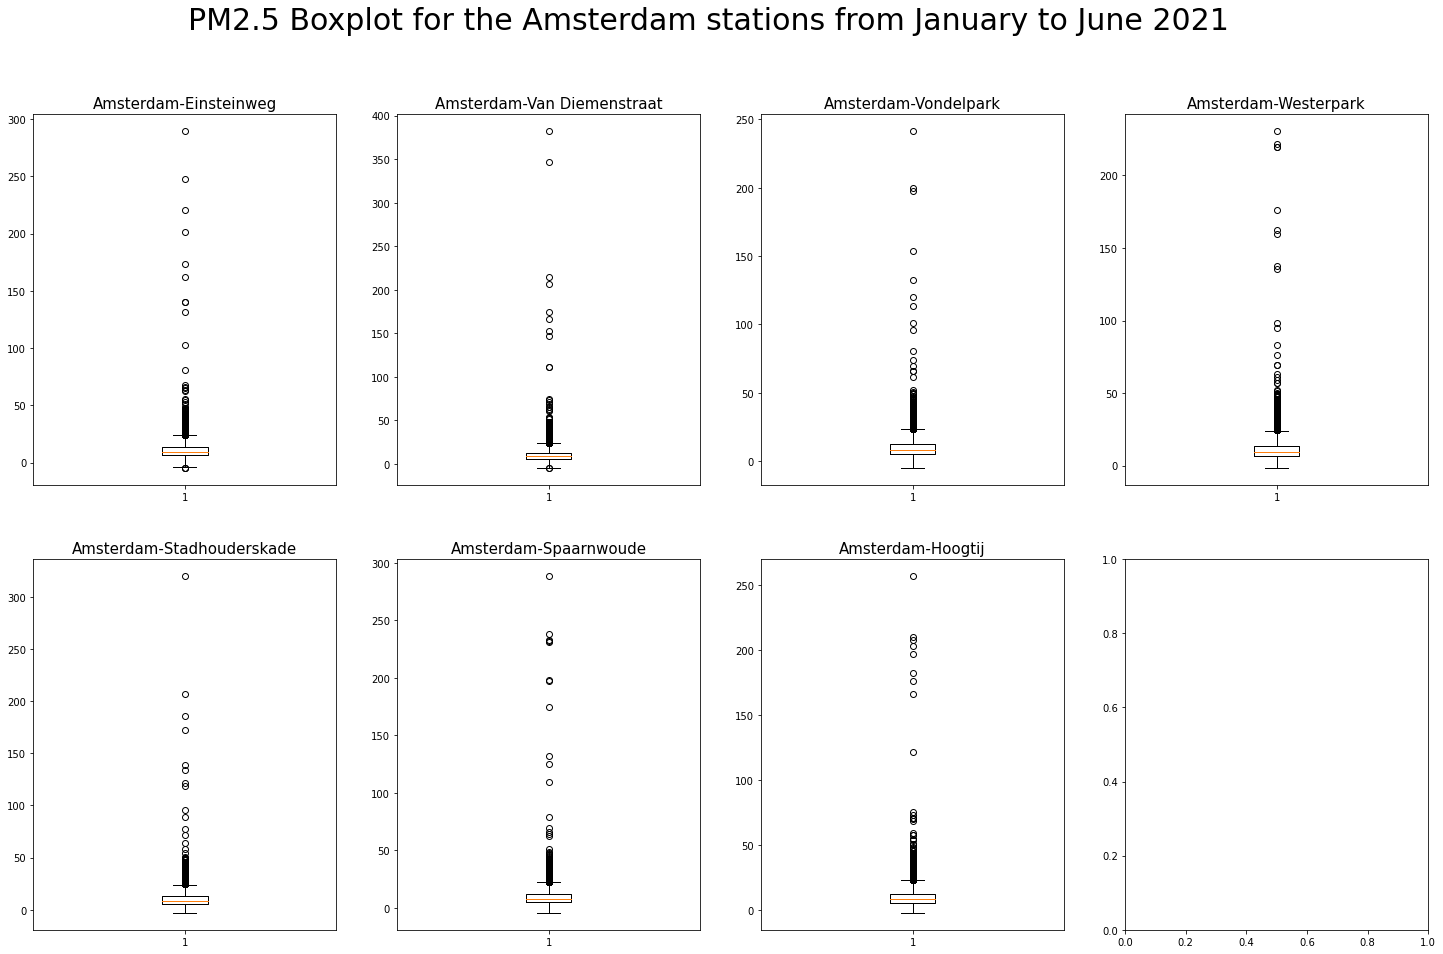

In [288]:
get_boxplot(filtpm25_ams,"PM2.5")

In [419]:
def plot_correlation(pm10_val,pm25_val,output_file_name,title):
    
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: pm10_val - (List) List of Tables with PM10 values for Amsterdam stations
    #         pm25_val - (List) List of Tables with PM2.5 values for Amsterdam stations
    #         output_file_name - (str) File name to save the plot
    # Purpose: Plots the correlation on the air quality data between pm10
    #          and pm2.5 and saves the plot
    # Returns: None
    
    fig = plt.figure(figsize=(30, 30))
    for i in range(len(pm25_stations)):
        n1 = np.array(pm10_val[i]["value"])
        n2 = np.array(pm25_val[i]["value"])
        plt.subplot(3,3,i+1)
        plt.scatter(n1,n2)
        m, b = np.polyfit(n1, n2, 1)
        #add linear regression line to scatterplot 
        plt.plot(n1, m*n1+b,color="red")
        r,p = stats.pearsonr(n1, n2)
        station_name = list(pm25_stations.keys())[i]
        plt.title(station_name+" (r = {:.4f})".format(r),fontsize = 20)

    plt.suptitle(title, fontsize = 30)
    fig.supxlabel("PM 10 values (µg/$m^3$)",y=0.1,fontsize = 20)
    fig.supylabel("PM 2.5 values (µg/$m^3$)",x=0.085,fontsize = 20)

    plt.savefig(f"output/{output_file_name}.png")

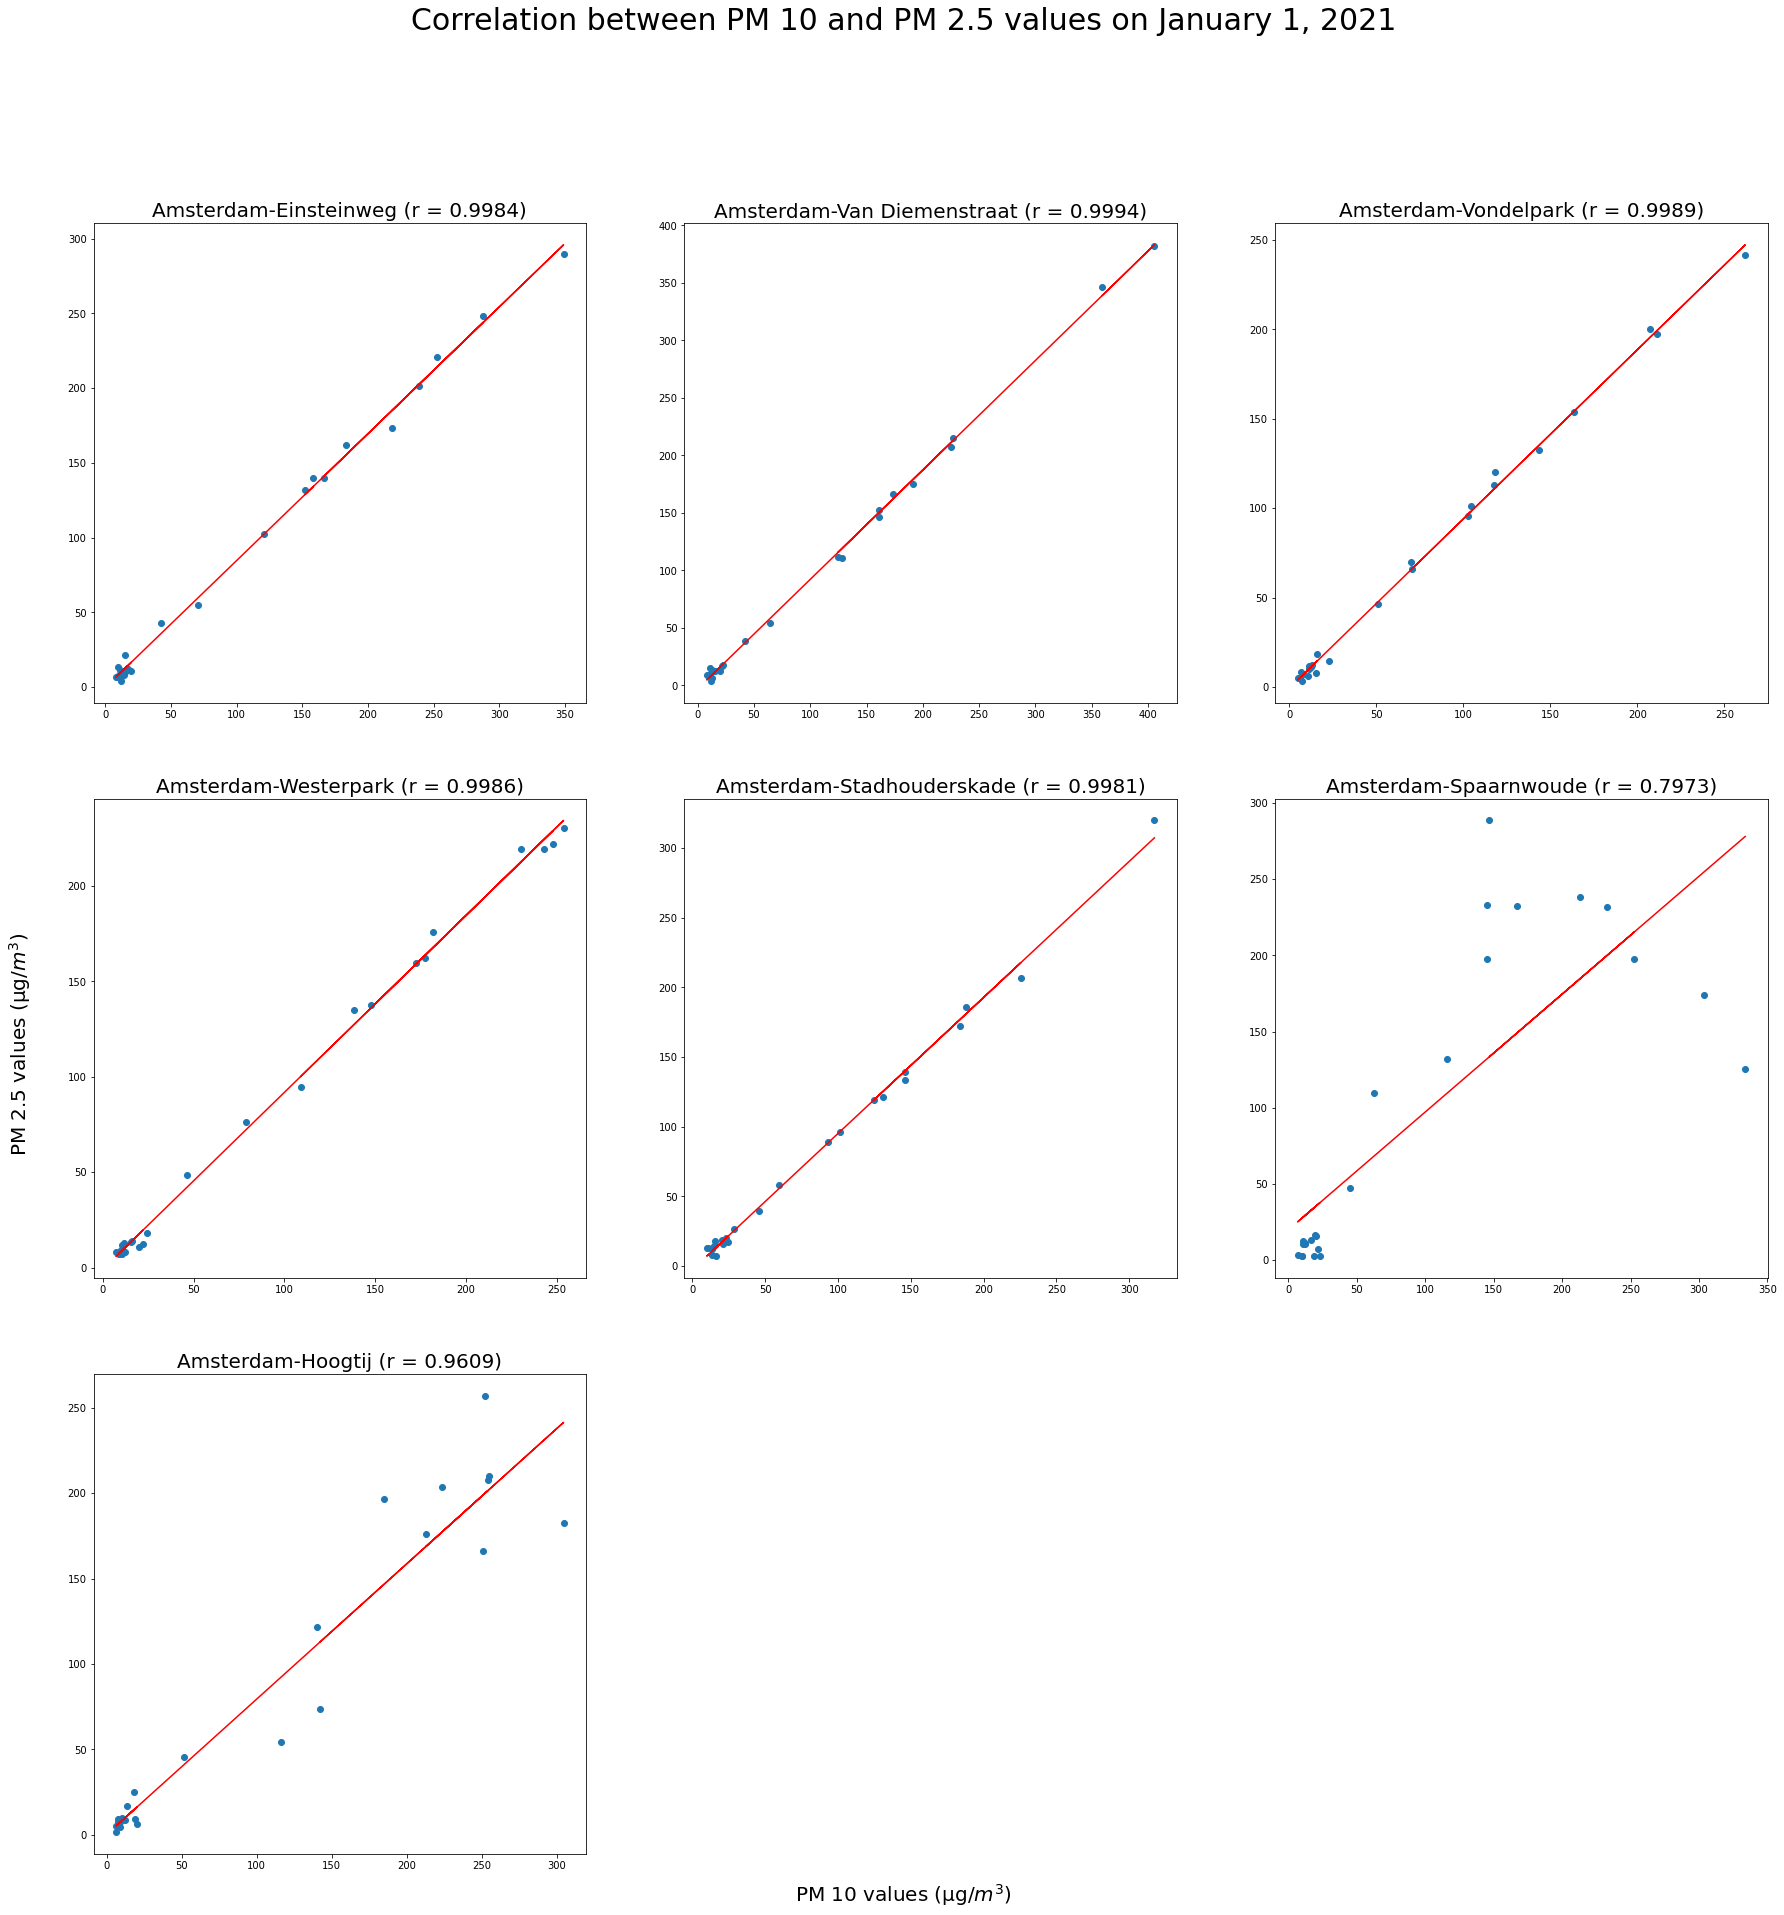

In [420]:
plot_correlation(pm10jan1_val,pm25jan1_val,"correlation_jan1",
                 "Correlation between PM 10 and PM 2.5 values on January 1, 2021")

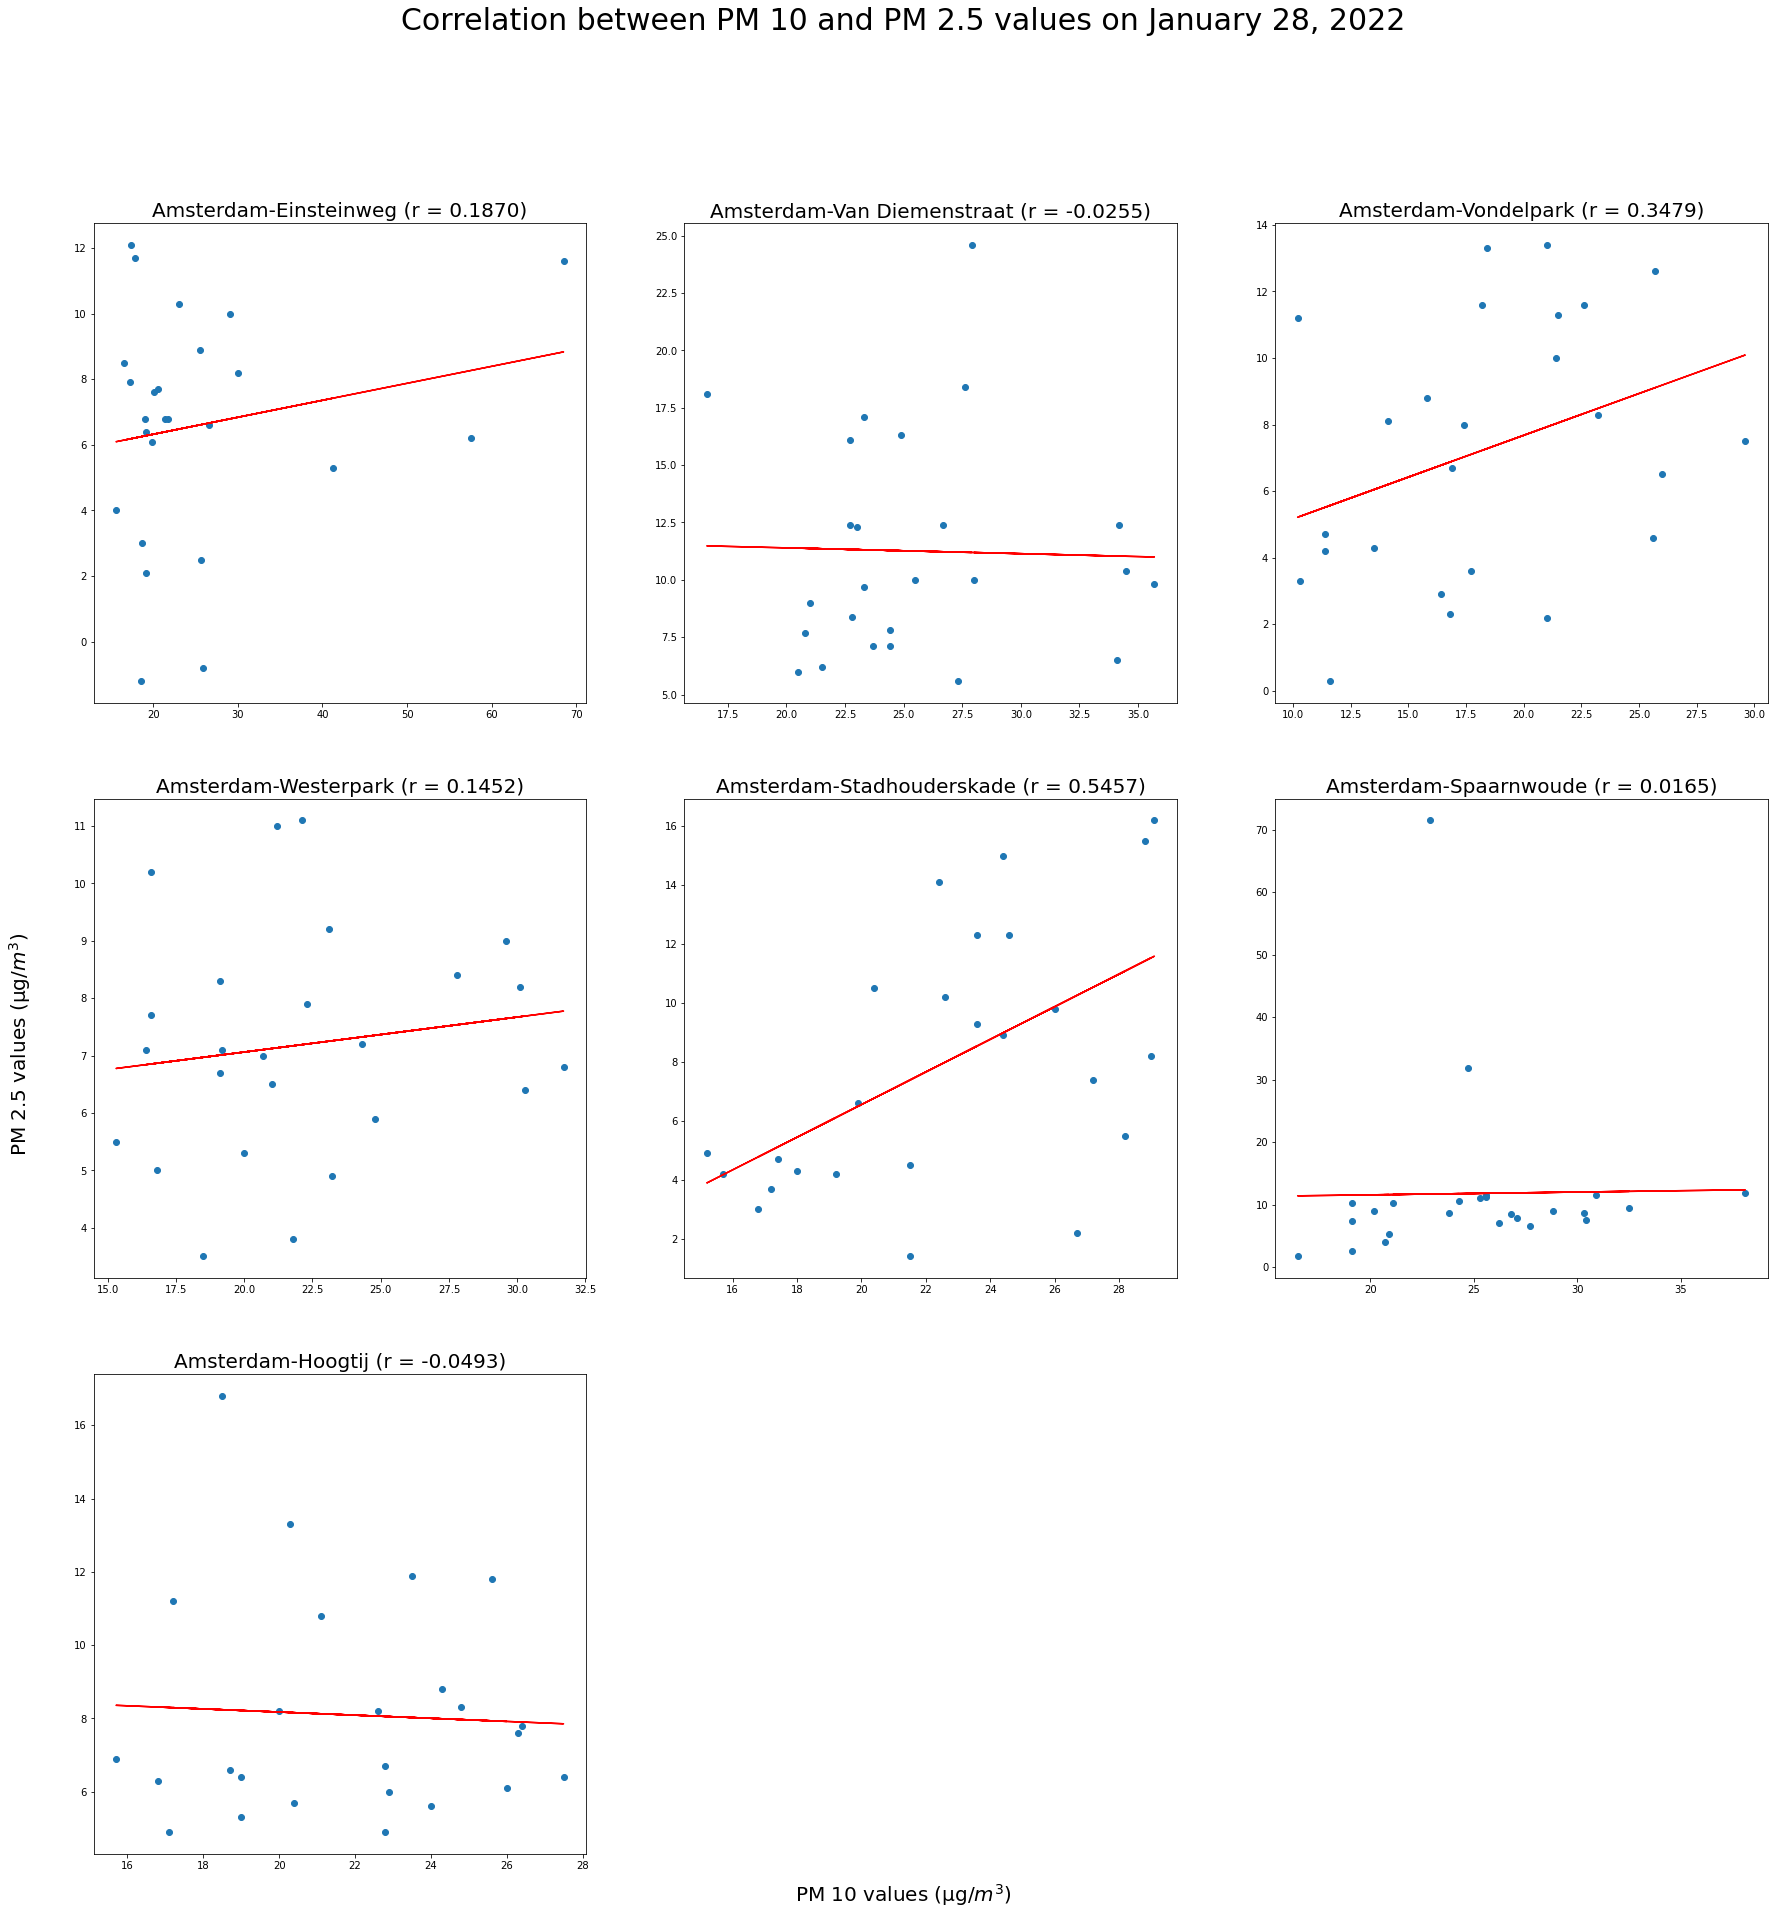

In [421]:
plot_correlation(pm10jan28_val,pm25jan28_val,"correlation_jan28",
                 "Correlation between PM 10 and PM 2.5 values on January 28, 2022")

In [422]:
pm10_monthly = [air_quality_monthly[i][0][0][1] for i in range(0,11)]
pm25_monthly = [air_quality_monthly[i][0][1][1] for i in range(0,11)]
monthly_vals = [pm10_monthly,pm25_monthly]
pm10_monthly_gdf_list,pm25_monthly_gdf_list = [[get_geodf(i) for i in i_air_q]
                                                for i_air_q in monthly_vals]
def save_shp_file(gdf_list,name):
    # Function to save shape files in a list
    for i in range(0,11):
        if gdf_list[i] is not None:
            gdf_list[i].to_file(f"output/{name}_{i+1}.shp")
            
save_shp_file(pm10_monthly_gdf_list,"pm10_month")
save_shp_file(pm25_monthly_gdf_list,"pm2.5_month")


In [423]:
month_map = {
    0:"January",
    1:"February",
    2:"March",
    3:"April",
    4:"May",
    5:"June"
}

def plot_monthly_idw(air_quality_param):
    
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: air_quality_param - (str) the air quality variable "pm10" or "pm2.5"
    #
    # Purpose: Plots the IDW interpolation on the air quality data on a monthly basis
    #          and saves the plot. 
    # Note: The idw must have been performed for the monthly data beforehand.
    # Returns: None
    
    files = glob.glob(f"output/{air_quality_param}_month*.shp")
    pm10_monthly_idw = [get_idw_interpolation(f) for f in files]
    plot_colno = math.ceil(len(pm10_monthly_idw)/2)
    fig,ax = plt.subplots(2,plot_colno,figsize=(20,10),squeeze=False,sharey=True,sharex=True)
    # print(plot_colno)
    title = air_quality_param.upper()+" monthly Interpolation for 2021"
    fig.suptitle(title,fontsize=30)
    for i_plt in range(0,len(pm10_monthly_idw)):
        if i_plt >= plot_colno:
            pplt = ax[1,i_plt-plot_colno].imshow(pm10_monthly_idw[i_plt][1],cmap="Reds")
            ax[1,i_plt-plot_colno].axis('off')
            ax[1,i_plt-plot_colno].set_title(month_map[i_plt],fontsize=20)
            fig.colorbar(pplt,ax=ax[1,i_plt-plot_colno]).set_label(size=15,label="Air Quality level (µg/$m^3$)")
        else:
            pplt = ax[0,i_plt].imshow(pm10_monthly_idw[i_plt][1],cmap="Reds")
            ax[0,i_plt].axis('off')
            ax[0,i_plt].set_title(month_map[i_plt],fontsize=20)
            fig.colorbar(pplt,ax=ax[0,i_plt]).set_label(size=15,label="Air Quality level (µg/$m^3$)")
    fig.savefig(f"output/montlhy_interpolated_{air_quality_param}.png")

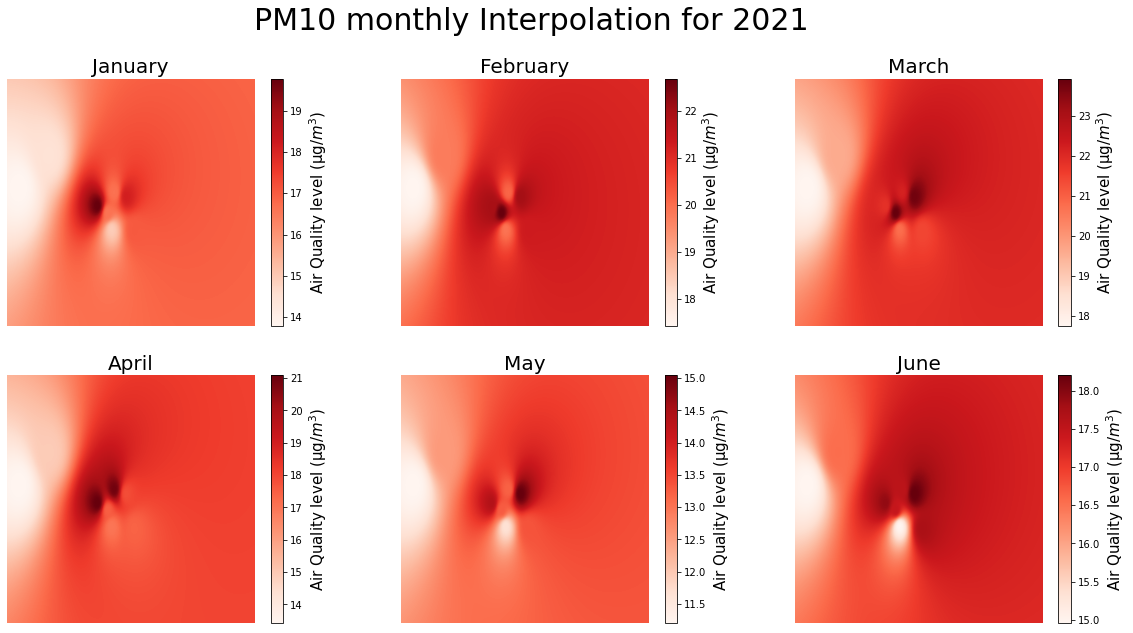

In [424]:
plot_monthly_idw("pm10")

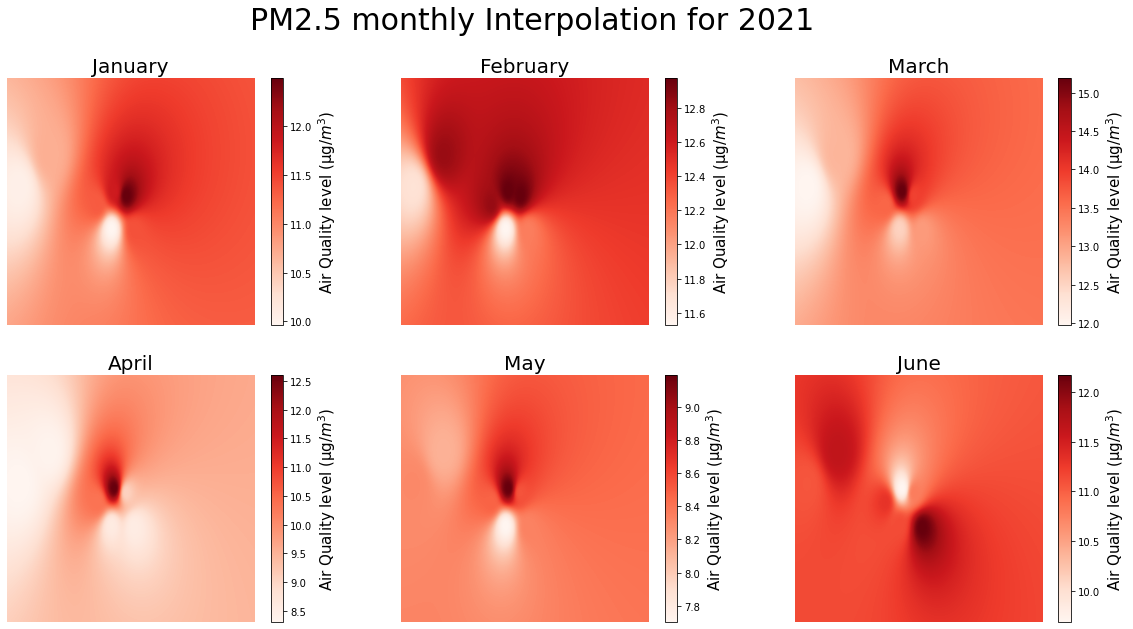

In [276]:
plot_monthly_idw("pm2.5")

In [306]:
landuse_path = r"landuse_data/landuse_city/landuse_amsterdam.shp"
districts_path = r"landuse_data/city_district/amsterdam_gemeenten.shp"

# Read the shape files of landuse and districts
landuse = gpd.read_file(landuse_path)
districts = gpd.read_file(districts_path)

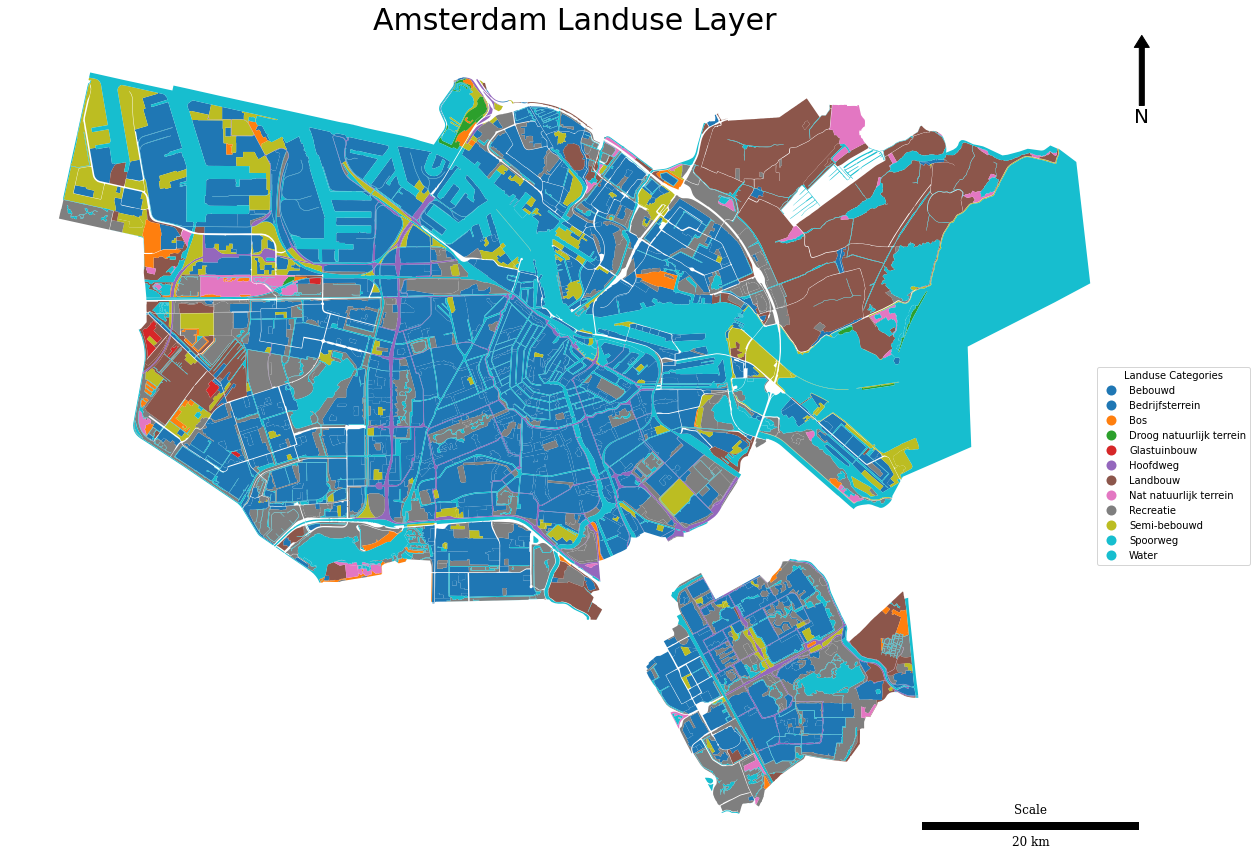

In [425]:

# Plotting the landuse map and saving the plot
ax = landuse.plot(column ="Hoofdgroep",legend=True,figsize=(30,15))
ax.set_title("Amsterdam Landuse Layer",fontsize=30)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.5, 0.1, 0.1))
leg.set_title("Landuse Categories")
ax.set_axis_off()
# Set scale bar
scale3 = ScaleBar(
    location = "lower right",
    dx=4, label="Scale",
    font_properties={'family':'serif', 'size': 'large'},  # For more information, see the cell below
    scale_formatter=lambda value, unit: f'{value} {unit}',
    animated=True
)
ax.add_artist(scale3)
# Set North arrow
x, y, arrow_length = 1, 1, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
plt.savefig("output/landuse_ams.png")



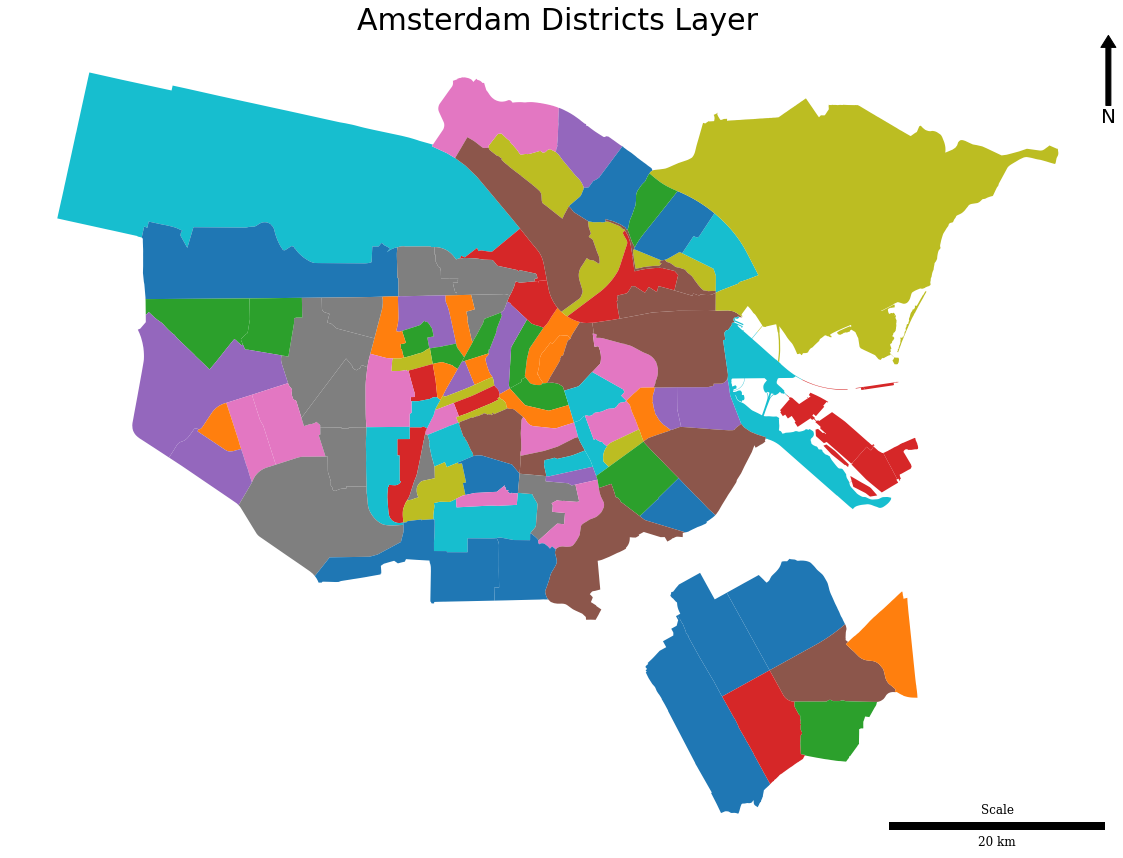

In [308]:

# Plotting the districts map and saving the plot
ax = districts.plot(column="wijknaam",figsize=(30,15))
ax.set_title("Amsterdam Districts Layer",fontsize=30)
ax.set_axis_off()
# Set the scale bar
scale3 = ScaleBar(
    location = "lower right",
    dx=4, label="Scale",
    font_properties={'family':'serif', 'size': 'large'},  # For more information, see the cell below
    scale_formatter=lambda value, unit: f'{value} {unit}',
    animated=True
)
ax.add_artist(scale3)

# Set the north arrow
x, y, arrow_length = 1, 1, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
plt.savefig("output/district_ams.png")


In [309]:

def set_mean_air_quality_df(gdal_ds,shp_file_path,geo_df,objid,air_q_var):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: gdal_ds - Interpolated Raster layer
    #         shp_file_path - (path) Path to the input shape file
    #         geo_df - (Dataframe) The Geo Dataframe of the input layer
    #         objid - (str) the attribute used to filter the features
    #         air_q_var - (str) The name provided to the new attributes created
    # Purpose: To warp the interpolated layer and set a mean value for each feature
    # Returns: None

    shp_file = ogr.Open(shp_file_path)
    
    # Extracting the shapefile layer

    shp_file_layer = shp_file.GetLayer(0)
    clippedDs = []
    for feature in shp_file_layer:
        code = feature.GetFieldAsString(objid)  
        clippedDs = gdal.Warp("",
                            gdal_ds, format="Mem",
                            cutlineDSName=shp_file_path,
                            cutlineWhere=f"{objid} = '{code}'",
                            cropToCutline=False)   
        try:
            
            clipped_array = gdal_array.DatasetReadAsArray(clippedDs)
            if np.all(clipped_array == 0 ):
                continue
            else:
                
                geo_df.loc[geo_df[objid] == code,f'{air_q_var}_avg'] = clipped_array[np.nonzero(clipped_array)].mean()
                geo_df.loc[geo_df[objid] == code,f'{air_q_var}_min'] = clipped_array[np.nonzero(clipped_array)].min()
                geo_df.loc[geo_df[objid] == code,f'{air_q_var}_max'] = clipped_array[np.nonzero(clipped_array)].max()
                
        except Exception as e:
            print(code)
            raise e
        clippedDs = None

In [310]:
# Overlay interpolation and get mean for the features
set_mean_air_quality_df(pm10_idw[0],districts_path,districts,"wijkcode","pm10year")
set_mean_air_quality_df(pm25_idw[0],districts_path,districts,"wijkcode","pm25year")

In [311]:
set_mean_air_quality_df(pm10_day_idw[0],districts_path,districts,"wijkcode","pm10jan1")
set_mean_air_quality_df(pm25_day_idw[0],districts_path,districts,"wijkcode","pm25jan1")

In [313]:
set_mean_air_quality_df(pm10jan28_idw[0],districts_path,districts,"wijkcode","pm10jan28")
set_mean_air_quality_df(pm25jan28_idw[0],districts_path,districts,"wijkcode","pm25jan28")

In [426]:

def plot_pm_vals(geodf,pm10,pm25,title,output_file_name):

    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: geodf - (Geodataframe) The geodataframe having the air quality values
    #         pm25 - (str) The pm2.5 mean column name
    #         pm10 - (str) The pm10 mean column name
    #         title - (str) The title of the plot
    #         output_file_name - (str) The file name to save the plot
    # Purpose: To plot the pm10 and pm2.5 features for the geodataframe and save it.
    # Returns: None
    
    fig,ax = plt.subplots(nrows=2,ncols=1, sharex=True,figsize=(15,15), sharey=True,squeeze=False)
    fig.suptitle(title,fontsize=20)
    dax = geodf.plot(ax=ax[0][0],column = pm10,legend=True,
                  legend_kwds={'label': "Air Quality level (µg/$m^3$)",
                            'shrink':0.6})
    

    # Add north arrow
    x, y, arrow_length = 1.2, 1.2, 0.1
    dax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20,
                xycoords=dax.transAxes)
    dax.set_title("PM 10 Level",fontsize=15)
    dax.set_axis_off()


    dax1= geodf.plot(ax=ax[1,0],column = pm25,legend=True,
                  legend_kwds={'label': "Air Quality level (µg/$m^3$)",
                            'shrink':0.6})
    # Set scale bar
    scale3 = ScaleBar(
        location = "lower right",
        dx=4, label="Scale",
        font_properties={'family':'serif', 'size': 'large'},  # For more information, see the cell below
        scale_formatter=lambda value, unit: f'{value} {unit}',
        animated=True
    )
    dax1.add_artist(scale3)
    dax1.set_title("PM 2.5 Level",fontsize=15)

    dax1.set_axis_off()
    fig.savefig(f"output/{output_file_name}.png")


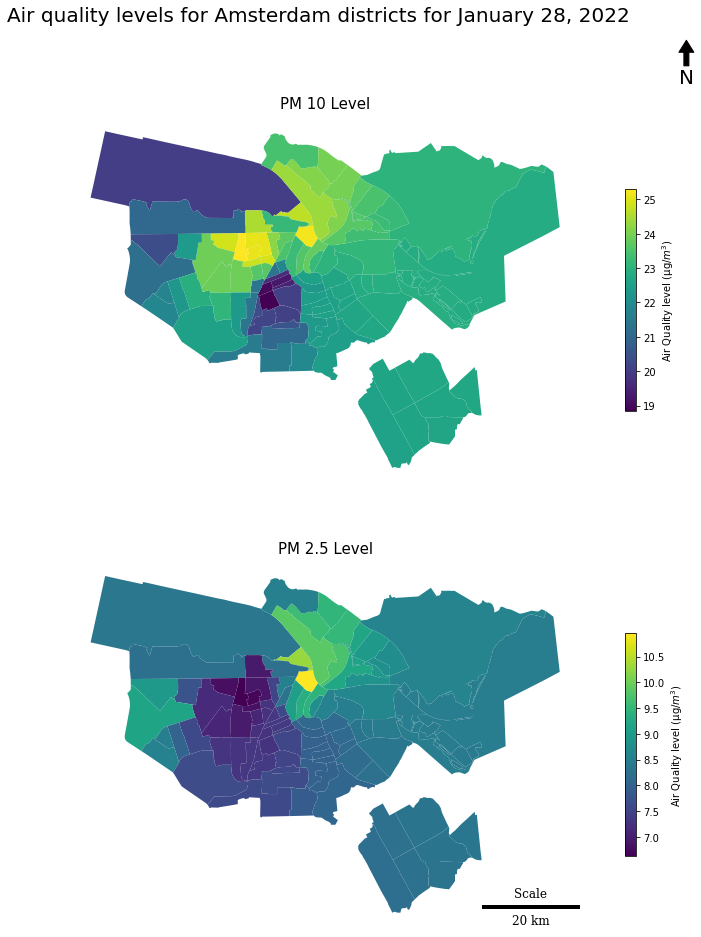

In [427]:
plot_pm_vals(districts,"pm10jan28_avg","pm25jan28_avg",
             "Air quality levels for Amsterdam districts for January 28, 2022","district_amster_jan28_2022")

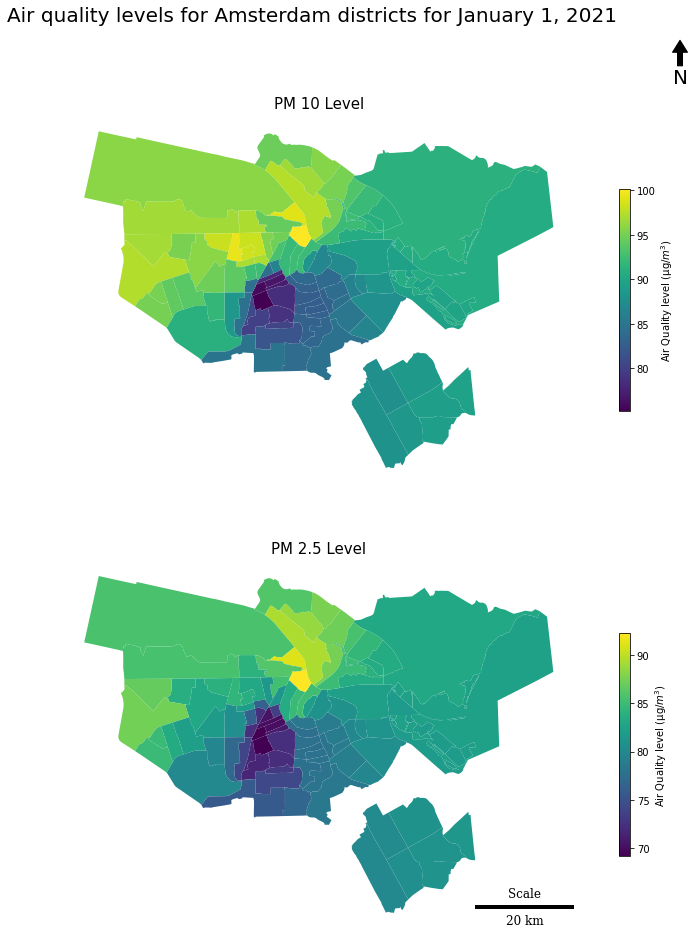

In [337]:
plot_pm_vals(districts,"pm10jan1_avg","pm25jan1_avg",
             "Air quality levels for Amsterdam districts for January 1, 2021","district_amster_jan1_2021")

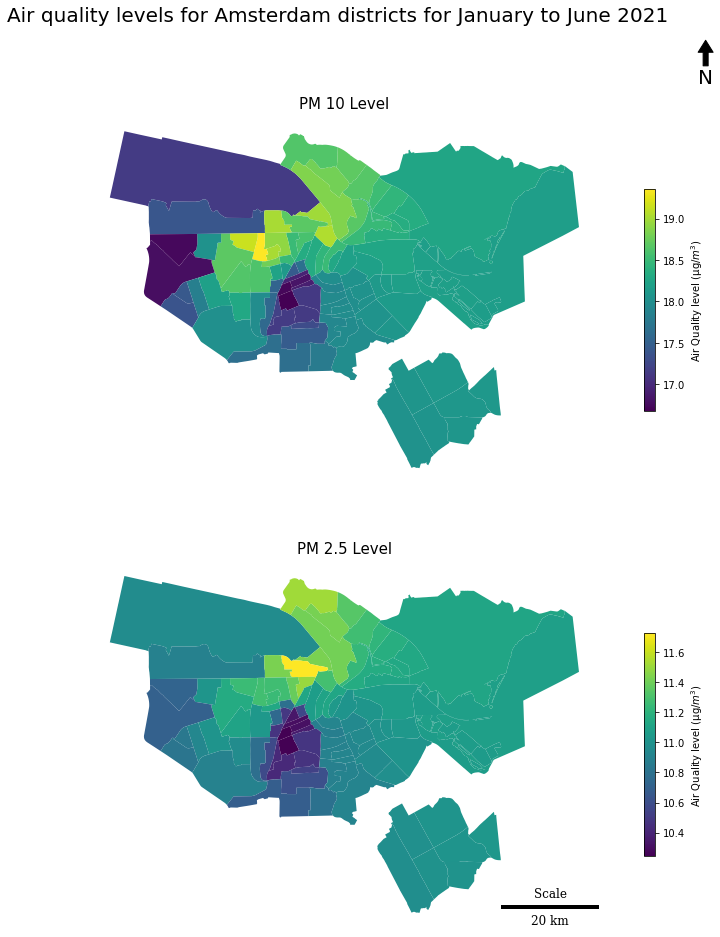

In [338]:
plot_pm_vals(districts,"pm10year_avg","pm25year_avg",
             "Air quality levels for Amsterdam districts for January to June 2021","district_amster_jan_jun_2021")

In [318]:
# districts.columns
districts.to_file("output/districts_airq.shp")

C:\Users\HP\AppData\Local\Temp/ipykernel_3980/1293868129.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  districts.to_file("output/districts_airq.shp")


In [320]:
# Add an unique field to select feautre by id
landuse["id"] = landuse.index + 1
landuse["id"] = landuse["id"].astype(str)
landuse.to_file("output/landuse_amsterdam_id.shp")

In [332]:
# Takes some time to run as there are several features in landue to warp
set_mean_air_quality_df(pm10jan28_idw[0],"output/landuse_amsterdam_id.shp",landuse,"id","pm10jan28")
set_mean_air_quality_df(pm25jan28_idw[0],"output/landuse_amsterdam_id.shp",landuse,"id","pm25jan28")

In [329]:
set_mean_air_quality_df(pm10_day_idw[0],"output/landuse_amsterdam_id.shp",landuse,"id","pm10jan1")
set_mean_air_quality_df(pm25_day_idw[0],"output/landuse_amsterdam_id.shp",landuse,"id","pm25jan1")

In [331]:
set_mean_air_quality_df(pm10_idw[0],"output/landuse_amsterdam_id.shp",landuse,"id","pm10year")
set_mean_air_quality_df(pm25_idw[0],"output/landuse_amsterdam_id.shp",landuse,"id","pm25year")

In [333]:
landuse.to_file("output/landuse_amsterdam_air_q.shp")

C:\Users\HP\AppData\Local\Temp/ipykernel_3980/2178522831.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  landuse.to_file("output/landuse_amsterdam_air_q.shp")


In [339]:
recreational_areas = landuse[landuse.Hoofdgroep == "Recreatie"]
# agriculture_areas = landuse[landuse.Hoofdgroep == "Landbouw"]

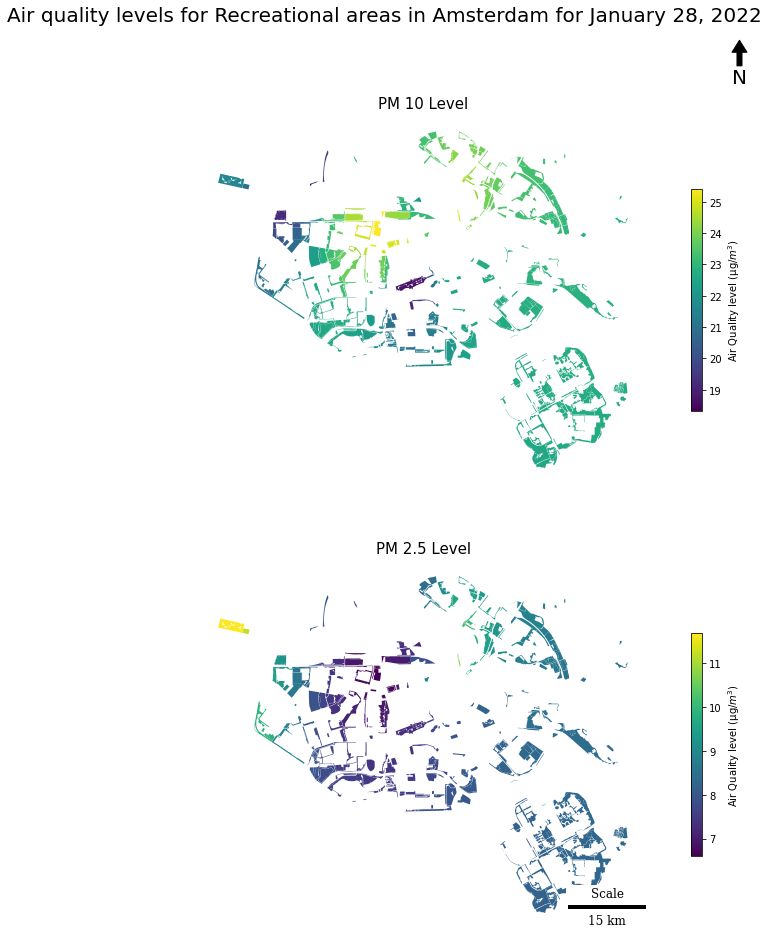

In [340]:
plot_pm_vals(recreational_areas,"pm10jan28_avg","pm25jan28_avg",
             "Air quality levels for Recreational areas in Amsterdam for January 28, 2022","recreatioanl_amster_jan28_2022")

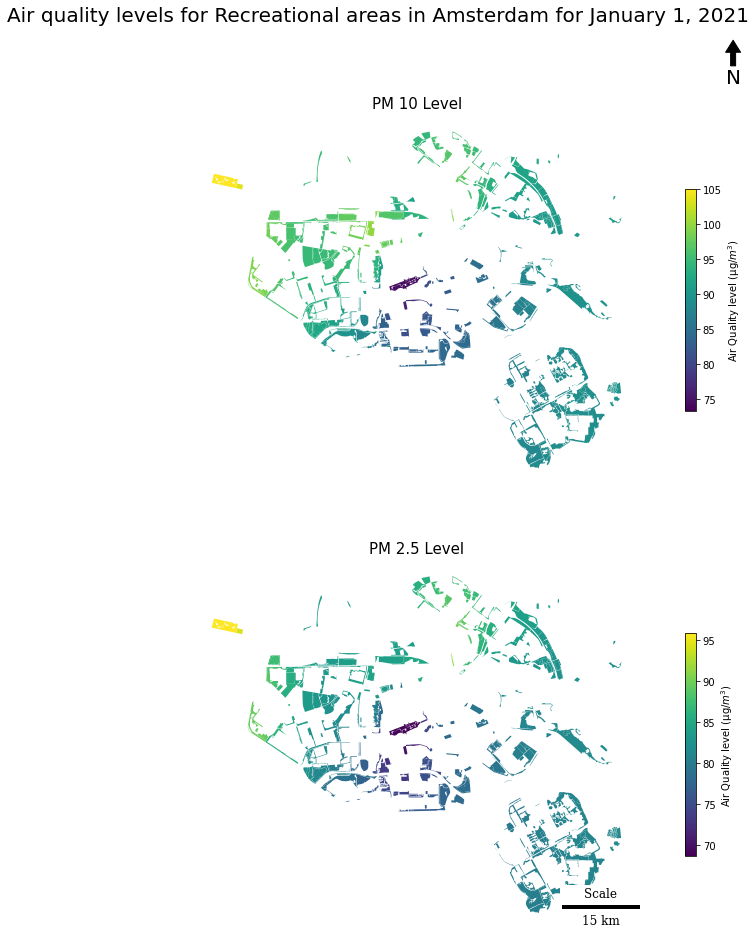

In [341]:
plot_pm_vals(recreational_areas,"pm10jan1_avg","pm25jan1_avg",
             "Air quality levels for Recreational areas in Amsterdam for January 1, 2021","recreatioanl_amster_jan1")

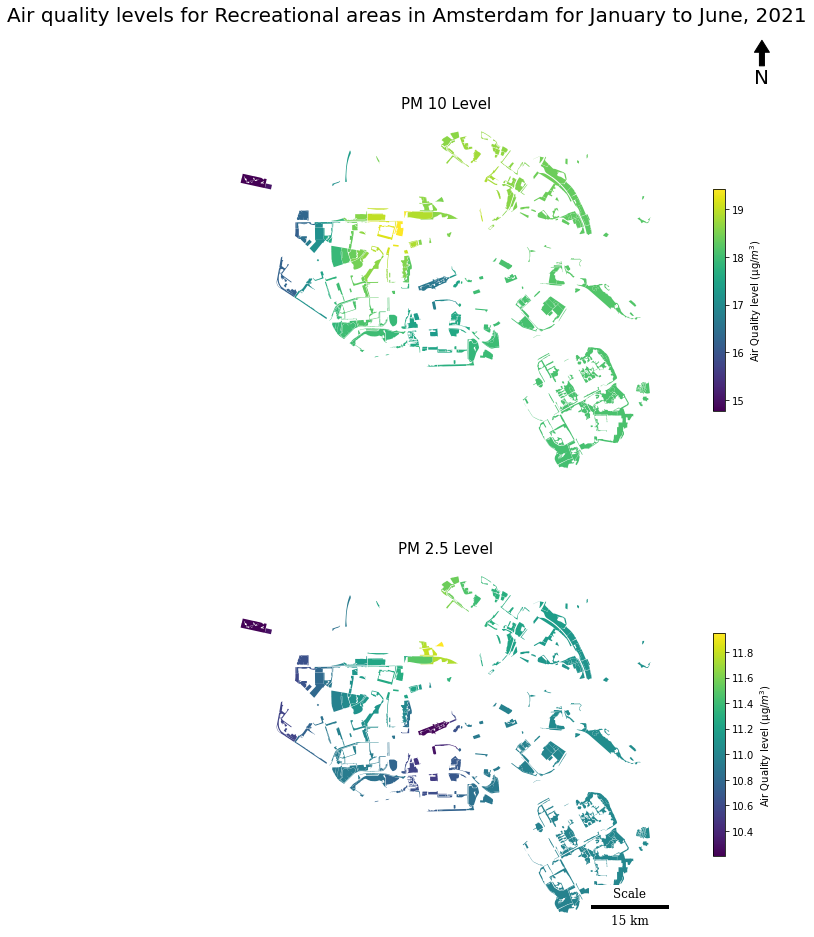

In [342]:
plot_pm_vals(recreational_areas,"pm10year_avg","pm25year_avg",
             "Air quality levels for Recreational areas in Amsterdam for January to June, 2021",
             "recreatioanl_amster_jan_jun")

In [343]:
agriculture_areas = landuse[landuse.Hoofdgroep == "Landbouw"]

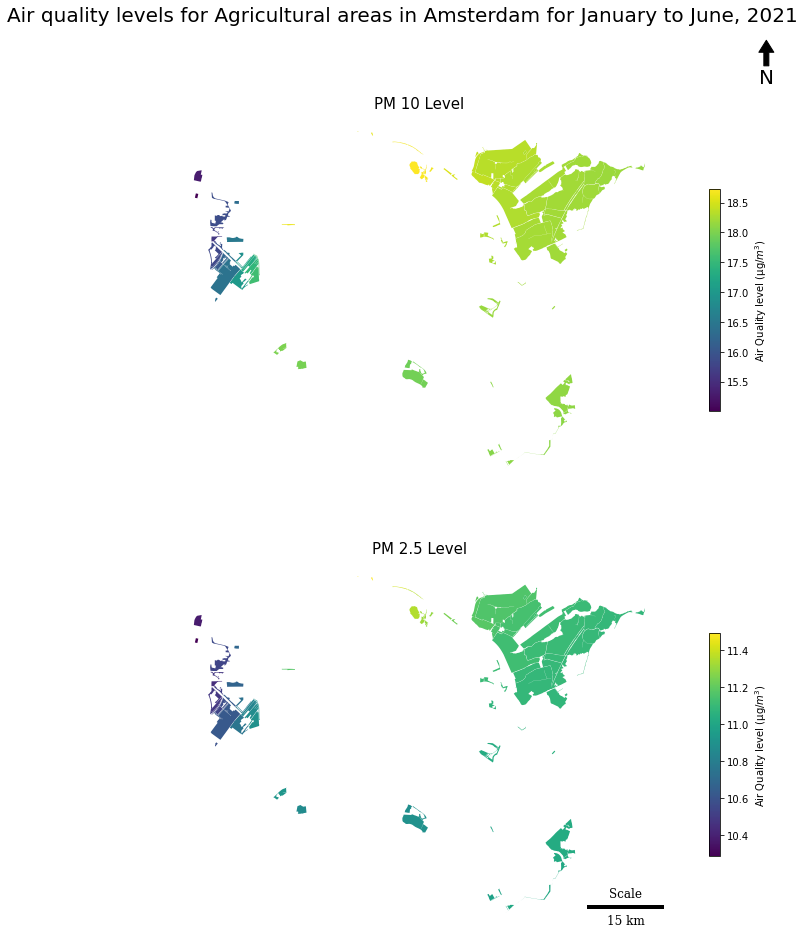

In [344]:
plot_pm_vals(agriculture_areas,"pm10year_avg","pm25year_avg",
             "Air quality levels for Agricultural areas in Amsterdam for January to June, 2021",
             "agricultural_amster_jan_jun")

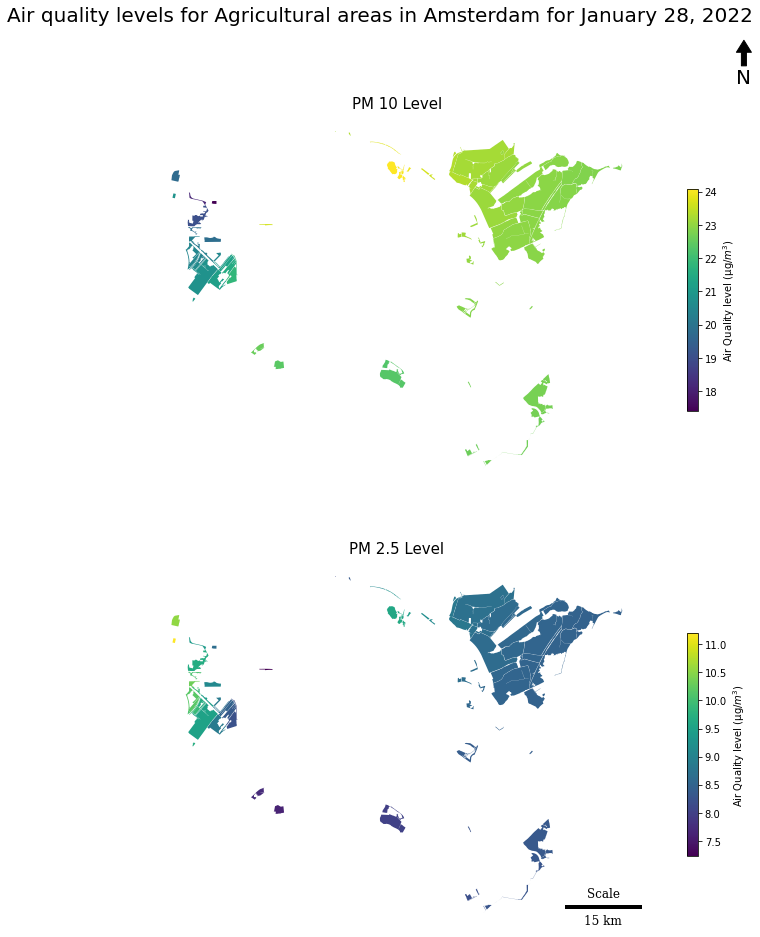

In [345]:
plot_pm_vals(agriculture_areas,"pm10jan28_avg","pm25jan28_avg",
             "Air quality levels for Agricultural areas in Amsterdam for January 28, 2022",
             "agricultural_amster_jan28")

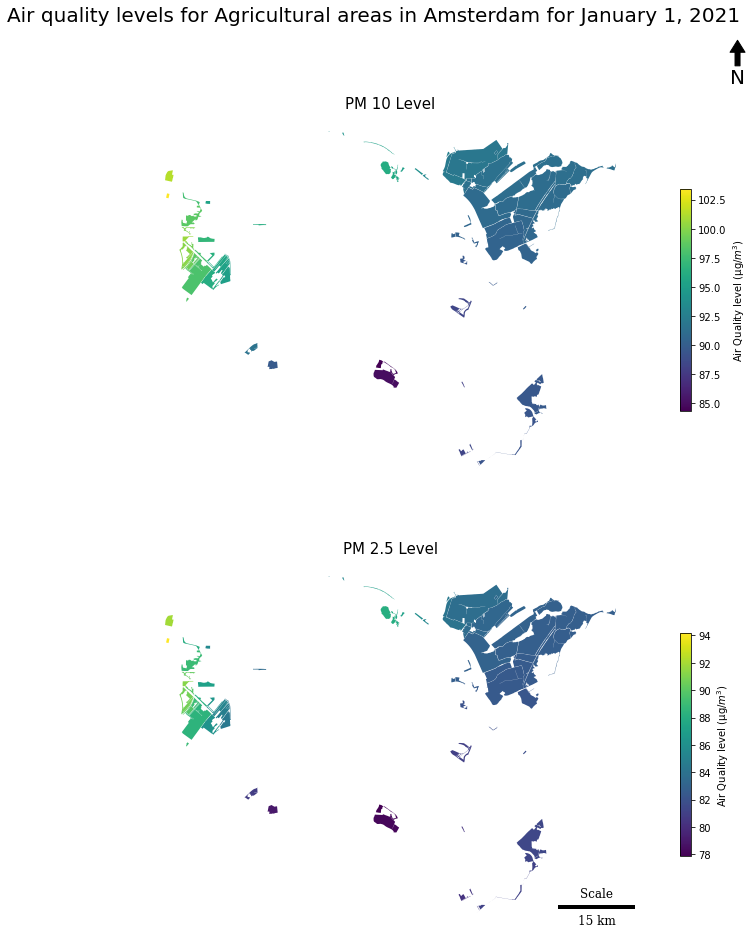

In [346]:
plot_pm_vals(agriculture_areas,"pm10jan1_avg","pm25jan1_avg",
             "Air quality levels for Agricultural areas in Amsterdam for January 1, 2021",
             "agricultural_amster_jan1")

In [347]:
road_ds_path = "landuse_data/roads/amsterdam_roads.shp"
road_ds = gpd.read_file(road_ds_path)


In [401]:
def save_roadDs_file(roadsRasterDs,roads_pm10,file_name):
    
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: roadsRasterDs - Raster layer to set projection for the roads
    #         roads_pm10 - (numpy.array) The array values for the road Dataset
    #         file_name - (str) The output file name to be saved.
    #
    # Purpose: Saves the road array to a raster file
    # Returns: None
    
    arr = roads_pm10

    driver = gdal.GetDriverByName("GTiff") # we can choose a diferent format e.g. XYZ
    newRaster = driver.Create(f"output/{file_name}.tif",arr.shape[1],arr.shape[0], 1,
    gdal.GDT_Float32)
    prj = roadsRasterDs.GetProjection() # define new raster dataset proj. & geotransform
    newRaster.SetProjection(prj)
    newRaster.SetGeoTransform(roadsRasterDs.GetGeoTransform())
    # We can use the same GT because TL is same
    newBand = newRaster.GetRasterBand(1) # get band 1 so we can fill it with data
    newBand.WriteArray(arr) # write the array to the band
    newBand.SetNoDataValue(-9999) # set a pixel nodata value
    newBand.FlushCache() # flush the cache and clean memory
    newRaster = None

In [403]:
def get_overlay_roads(pm_idw_ds,pm_idw_arr,road_ds_path,output_file_name):
    # Created By: Arun Venugopal
    # Created Date: 28-Jan-2022
    # Params: pm_idw_ds - (Interpolated Ds) Interpolated Raster layer
    #         pm_idw_arr - (numpy.array) The array values for the interpolated layer
    #         road_ds_path - (path) Path of the road layer
    #         output_file_name - (str) the name of the file to save the raster
    # Purpose: Gets the interpolated layer and rasterises the road layer 
    #          cascade the features. Results in a raod network with air quality levels
    # Returns: Road Dataset Array
    
    
    road_ds_ogr = ogr.Open(road_ds_path)
    road_ds_layer = road_ds_ogr.GetLayer()
    memDriver = gdal.GetDriverByName('Mem')
    roadsRasterDs = memDriver.Create('', pm_idw_ds.RasterXSize, pm_idw_ds.RasterYSize,1,gdal.GDT_Float32)

    # set projection and GeoTransform
    roadsRasterDs.SetProjection(pm_idw_ds.GetProjection())
    roadsRasterDs.SetGeoTransform(pm_idw_ds.GetGeoTransform())

    #  create 1 band and set the nodata value
    outband1 = roadsRasterDs.GetRasterBand(1)
    outband1.SetNoDataValue(0)
    gdal.RasterizeLayer(roadsRasterDs, [1], road_ds_layer, burn_values=[1])
    road_bands = gdal_array.DatasetReadAsArray(roadsRasterDs)
    overlay_road = pm_idw_arr * road_bands
    save_roadDs_file(roadsRasterDs,overlay_road,output_file_name)
    return overlay_road

In [404]:
pm25jan28_road_bands = get_overlay_roads(pm25jan28_1500idw[0],pm25jan28_1500idw[1],road_ds_path,"roadspm25Jan28")
pm10jan28_road_bands = get_overlay_roads(pm10jan28_1500idw[0],pm10jan28_1500idw[1],road_ds_path,"roadspm10Jan28")
pm25jan1_road_bands = get_overlay_roads(pm25_jan1_idw[0],pm25_jan1_idw[1],road_ds_path,"roadspm25Jan1")
pm10jan1_road_bands = get_overlay_roads(pm10_jan1_idw[0],pm10_jan1_idw[1],road_ds_path,"roadspm10Jan1")
pm10janJun_road_bands = get_overlay_roads(pm10_1500idw[0],pm10_1500idw[1],road_ds_path,"roadspm10JanJun")
pm25janJun_road_bands = get_overlay_roads(pm25_1500idw[0],pm25_1500idw[1],road_ds_path,"roadspm25JanJun")

In [394]:
def plot_road(road_band):
    # Function to plot the road array
    vmin = road_band[road_band.nonzero()].min()
    vmax = road_band[road_band.nonzero()].max()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(roads_pm25,cmap="tab10",interpolation = "nearest",vmin=vmin,vmax = vmax)

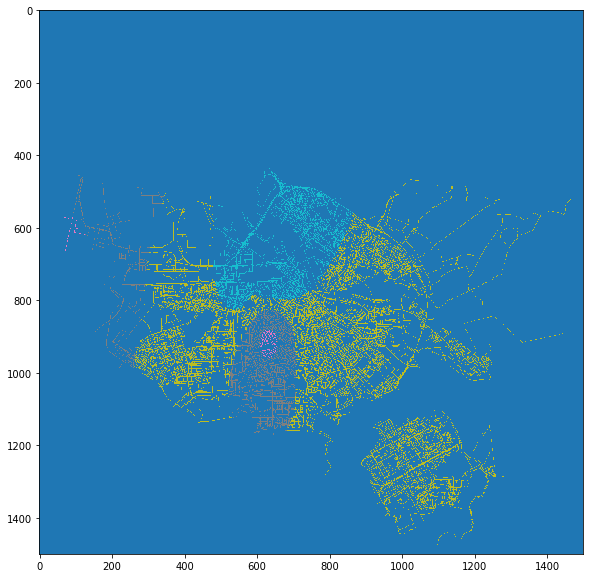

In [395]:
plot_road(pm25jan28_road_bands)

In [405]:
# Opensense data
opensense_data_folder = "opensense_data/"
opensense_files = glob.glob(f'{opensense_data_folder}*.csv')
pm10_files = [i for i in opensense_files
              if "PM10" in i]
pm25_files = [i for i in opensense_files
              if "PM2.5" in i]

In [406]:
# Read the opensense data
pm25_data = None
li = []
for filename in pm25_files:
    df = pd.read_csv(filename,delimiter=",")
    li.append(df)

    pm25_data = pd.concat(li, axis=0, ignore_index=True)

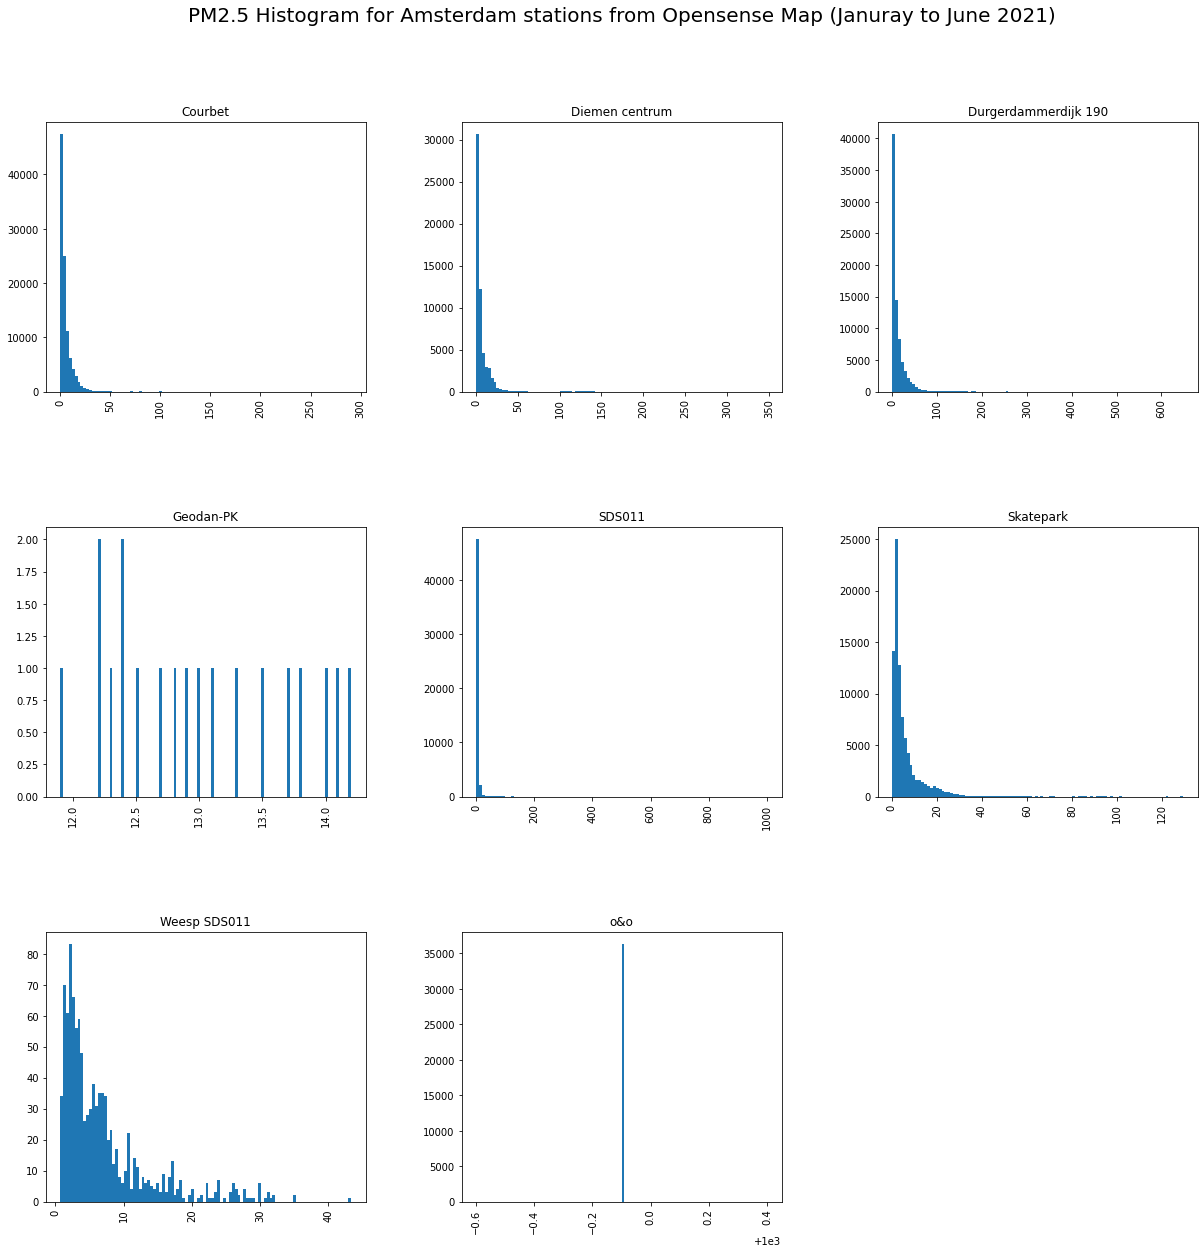

In [343]:
# Plotting the histograms for the data
pm25_data["value"].hist(by=pm25_data["boxName"],figsize=(20,20),bins=100)
pl.suptitle("PM2.5 Histogram for Amsterdam stations from Opensense Map (Januray to June 2021)",fontsize=20)
plt.savefig("output/pm25_open_hist_jan_jun.png")


In [321]:

# Read the opensense data
pm10_data = None
li = []
for filename in pm10_files:
    df = pd.read_csv(filename,delimiter=",")
    li.append(df)

    pm10_data = pd.concat(li, axis=0, ignore_index=True)

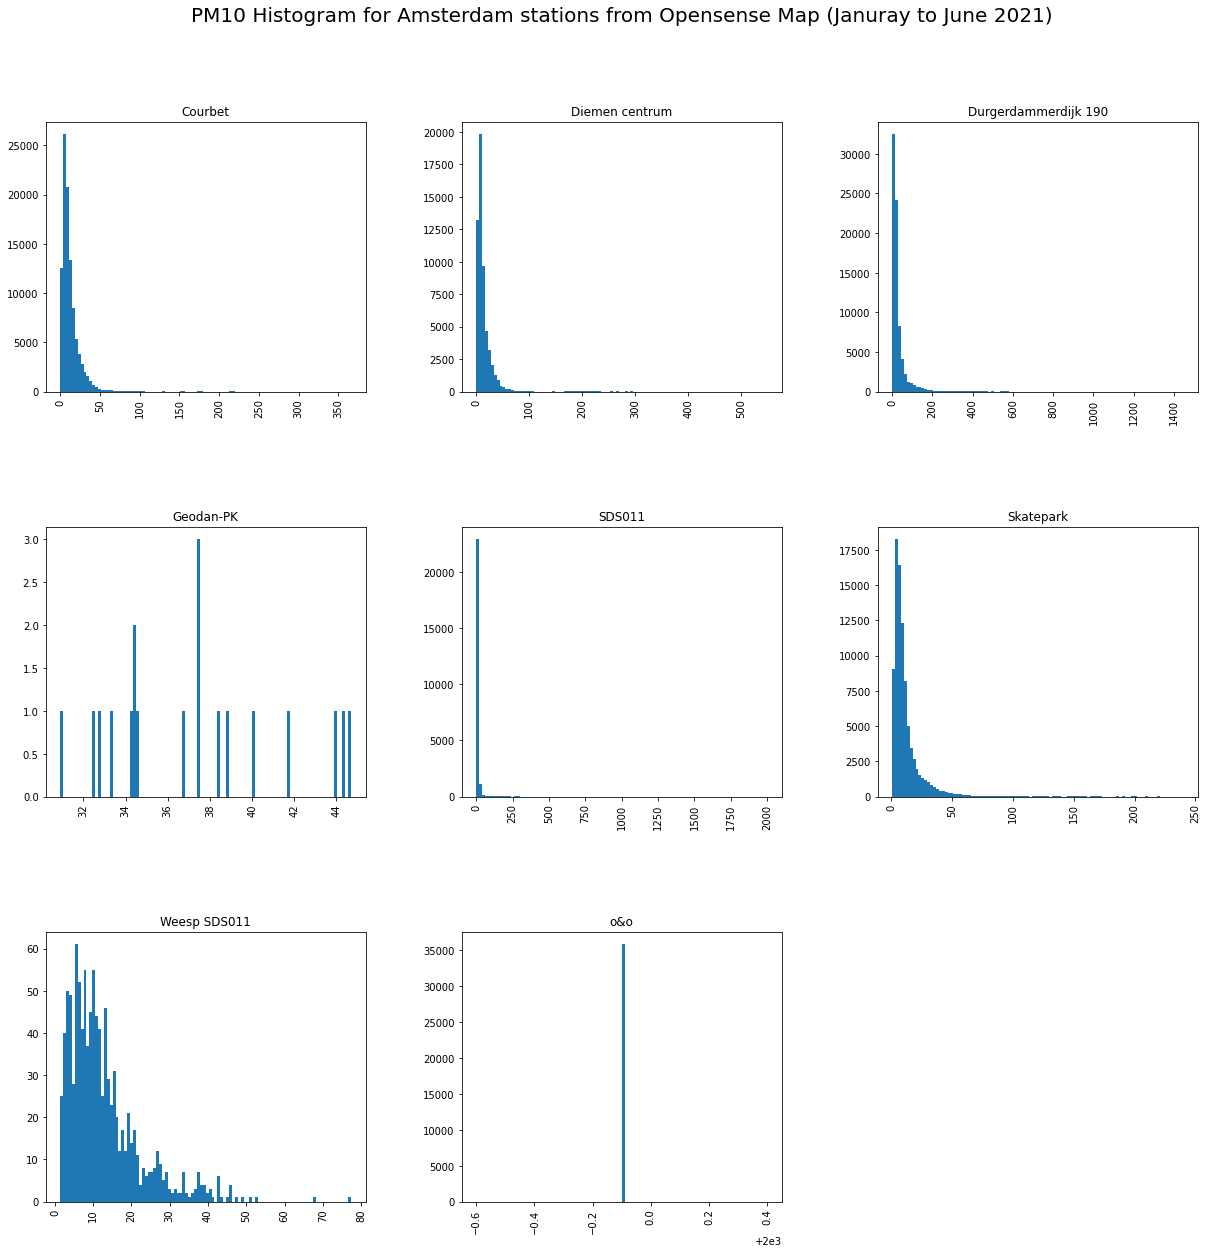

In [342]:
# Plotting the histograms for the data
pm10_open_hist = pm10_data["value"].hist(by=pm10_data["boxName"],figsize=(20,20),bins=100)
pl.suptitle("PM10 Histogram for Amsterdam stations from Opensense Map (Januray to June 2021)",fontsize=20)
plt.savefig("output/pm10_open_hist_jan_jun.png")

# Data not having accurate values. Not considered for analysis